The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 优化和深度学习

在本节中，我们将讨论优化与深度学习之间的关系以及在深度学习中使用优化的挑战。对于深度学习问题，我们通常会先定义*损失函数*。一旦我们有了损失函数，我们就可以使用优化算法来尝试最小化损失。在优化中，损失函数通常被称为优化问题的*目标函数*。按照传统和惯则，大多数优化算法都关注的是*最小化*。如果我们需要最大化目标，那么有一个简单的解决方案：在目标函数前加负号即可。

## 优化的目标

尽管优化提供了一种最大限度地减少深度学习损失函数的方法，但实质上，优化和深度学习的目标是根本不同的。前者主要关注的是最小化目标，后者则关注在给定有限数据量的情况下寻找合适的模型。在 :numref:`sec_model_selection`中，我们详细讨论了这两个目标之间的区别。例如，训练误差和泛化误差通常不同：由于优化算法的目标函数通常是基于训练数据集的损失函数，因此优化的目标是减少训练误差。但是，深度学习（或更广义地说，统计推断）的目标是减少泛化误差。为了实现后者，除了使用优化算法来减少训练误差之外，我们还需要注意过拟合。


In [ ]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

为了说明上述不同的目标，让我们考虑经验风险和风险。如 :numref:`subsec_empirical-risk-and-risk`所述，经验风险是训练数据集的平均损失，而风险则是整个数据群的预期损失。下面我们定义了两个函数：风险函数`f`和经验风险函数`g`。假设我们只有有限量的训练数据。因此，这里的`g`不如`f`平滑。


In [ ]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

下图说明，训练数据集的最低经验风险可能与最低风险（泛化误差）不同。


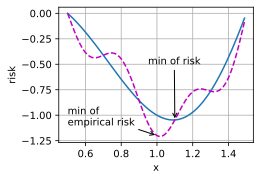

In [ ]:
def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

## 深度学习中的优化挑战

在本章中，我们将特别关注优化算法在最小化目标函数方面的性能，而不是模型的泛化误差。在 :numref:`sec_linear_regression`中，我们区分了优化问题中的解析解和数值解。在深度学习中，大多数目标函数都很复杂，没有解析解。相反，我们必须使用数值优化算法。本章中的优化算法都属于此类别。

深度学习优化存在许多挑战。其中一些最令人烦恼的是局部最小值、鞍点和梯度消失。让我们来看看它们。

### 局部最小值

对于任何目标函数$f(x)$，如果在$x$处对应的$f(x)$值小于在$x$附近任何其他点的$f(x)$值，那么$f(x)$可能是局部最小值。如果$f(x)$在$x$处的值是整个域上目标函数的最小值，那么$f(x)$是全局最小值。

例如，给定函数

$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$

我们可以近似该函数的局部最小值和全局最小值。


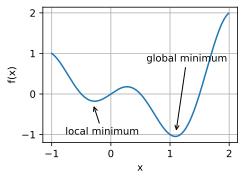

In [ ]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

深度学习模型的目标函数通常有许多局部最优解。当优化问题的数值解接近局部最优值时，随着目标函数解的梯度接近或变为零，通过最终迭代获得的数值解可能仅使目标函数*局部*最优，而不是*全局*最优。只有一定程度的噪声可能会使参数超出局部最小值。事实上，这是小批量随机梯度下降的有利特性之一，在这种情况下，小批量上梯度的自然变化能够将参数从局部极小值中移出。

### 鞍点

除了局部最小值之外，鞍点也是梯度消失的另一个原因。*鞍点*（saddle point）是指函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。考虑这个函数$f(x) = x^3$。它的一阶和二阶导数在$x=0$时消失。这时优化可能会停止，尽管它不是最小值。


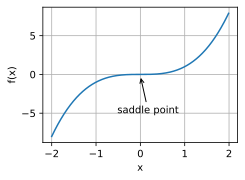

In [ ]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

如下例所示，较高维度的鞍点甚至更加隐蔽。考虑这个函数$f(x, y) = x^2 - y^2$。它的鞍点为$(0, 0)$。这是关于$y$的最大值，也是关于$x$的最小值。此外，它*看起来*像马鞍，这就是这个数学属性的名字由来。


/home/d2l-worker/miniconda3/envs/d2l-zh-release-1/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


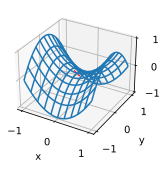

In [ ]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

我们假设函数的输入是$k$维向量，其输出是标量，因此其Hessian矩阵（也称黑塞矩阵）将有$k$特征值（参考[online appendix on eigendecompositions](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/eigendecomposition.html))。函数的解决方案可以是局部最小值、局部最大值或函数梯度为零的位置处的鞍点：

* 当函数在零梯度位置处的Hessian矩阵的特征值全部为正值时，我们有该函数的局部最小值。
* 当函数在零梯度位置处的Hessian矩阵的特征值全部为负值时，我们有该函数的局部最大值。
* 当函数在零梯度位置处的Hessian矩阵的特征值为负值和正值时，我们对函数有一个鞍点。

对于高维度问题，至少*部分*特征值为负的可能性相当高。这使得鞍点比局部最小值更有可能。我们将在下一节介绍凸性时讨论这种情况的一些例外情况。简而言之，凸函数是Hessian函数的特征值永远不是负值的函数。不幸的是，大多数深度学习问题并不属于这个类别。尽管如此，它还是研究优化算法的一个很好的工具。

### 梯度消失

可能遇到的最隐蔽的问题是梯度消失。回想一下我们在 :numref:`subsec_activation_functions`中常用的激活函数及其衍生函数。例如，假设我们想最小化函数$f(x) = \tanh(x)$，然后我们恰好从$x = 4$开始。正如我们所看到的那样，$f$的梯度接近零。更具体地说，$f'(x) = 1 - \tanh^2(x)$，因此是$f'(4) = 0.0013$。因此，在我们取得进展之前，优化将会停滞很长一段时间。事实证明，这是在引入ReLU激活函数之前训练深度学习模型相当棘手的原因之一。


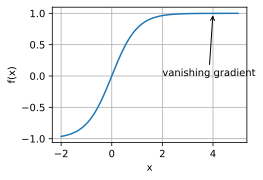

In [ ]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

正如我们所看到的那样，深度学习的优化充满挑战。幸运的是，有一系列强大的算法表现良好，即使对于初学者也很容易使用。此外，没有必要找到最佳解决方案。局部最优解或其近似解仍然非常有用。

## 小结

* 最小化训练误差并*不能*保证我们找到最佳的参数集来最小化泛化误差。
* 优化问题可能有许多局部最小值。
* 问题可能有更多的鞍点，因为通常问题不是凸的。
* 梯度消失可能会导致优化停滞，重参数化通常会有所帮助。对参数进行良好的初始化也可能是有益的。

## 练习

1. 考虑一个简单的MLP，它有一个隐藏层，比如，隐藏层中维度为$d$和一个输出。证明对于任何局部最小值，至少有$d！$个等效方案。
1. 假设我们有一个对称随机矩阵$\mathbf{M}$，其中条目$M_{ij} = M_{ji}$各自从某种概率分布$p_{ij}$中抽取。此外，假设$p_{ij}(x) = p_{ij}(-x)$，即分布是对称的（详情请参见 :cite:`Wigner.1958`）。
    1. 证明特征值的分布也是对称的。也就是说，对于任何特征向量$\mathbf{v}$，关联的特征值$\lambda$满足$P(\lambda > 0) = P(\lambda < 0)$的概率为$P(\lambda > 0) = P(\lambda < 0)$。
    1. 为什么以上*没有*暗示$P(\lambda > 0) = 0.5$？
1. 你能想到深度学习优化还涉及哪些其他挑战？
1. 假设你想在（真实的）鞍上平衡一个（真实的）球。
    1. 为什么这很难？
    1. 你也能利用这种效应来优化算法吗？


# 凸性
:label:`sec_convexity`

*凸性*（convexity）在优化算法的设计中起到至关重要的作用，
这主要是由于在这种情况下对算法进行分析和测试要容易得多。
换言之，如果该算法甚至在凸性条件设定下的效果很差，
通常我们很难在其他条件下看到好的结果。
此外，即使深度学习中的优化问题通常是非凸的，
它们也经常在局部极小值附近表现出一些凸性。
这可能会产生一些像 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`这样比较有意思的新的优化变体。


In [ ]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

## 定义

在进行凸分析之前，我们需要定义*凸集*（convex sets）和*凸函数*（convex functions）。

### 凸集

*凸集*（convex set）是凸性的基础。
简单地说，如果对于任何$a，b \in \mathcal{X}$，连接$a$和$b$的线段也位于$\mathcal{X}$中，则向量空间中的一个集合$\mathcal{X}$是*凸*（convex）的。
在数学术语上，这意味着对于所有$\lambda \in [0, 1]$，我们得到

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ 当 } a, b \in \mathcal{X}.$$

这听起来有点抽象，那我们来看一下 :numref:`fig_pacman`里的例子。
第一组存在不包含在集合内部的线段，所以该集合是非凸的，而另外两组则没有这样的问题。

![第一组是非凸的，另外两组是凸的。](http://d2l.ai/_images/pacman.svg)
:label:`fig_pacman`

有了定义做什么呢？
我们来看一下交集 :numref:`fig_convex_intersect`。
假设$\mathcal{X}$和$\mathcal{Y}$是凸集，那么$\mathcal {X} \cap \mathcal{Y}$也是凸集的。
现在考虑任意$a, b \in \mathcal{X} \cap \mathcal{Y}$，
因为$\mathcal{X}$和$\mathcal{Y}$是凸集，
所以连接$a$和$b$的线段包含在$\mathcal{X}$和$\mathcal{Y}$中。
鉴于此，它们也需要包含在$\mathcal {X} \cap \mathcal{Y}$中，从而证明我们的定理。

![两个凸集的交集是凸的。](../img/convex-intersect.svg)
:label:`fig_convex_intersect`

我们可以毫不费力地进一步得到这样的结果：
给定凸集$\mathcal{X}_i$，它们的交集$\cap_{i} \mathcal{X}_i$是凸的。
但是反向是不正确的，考虑两个不相交的集合$\mathcal{X} \cap \mathcal{Y} = \emptyset$，
取$a \in \mathcal{X}$和$b \in \mathcal{Y}$。
因为我们假设$\mathcal{X} \cap \mathcal{Y} = \emptyset$，
在 :numref:`fig_nonconvex`中连接$a$和$b$的线段需要包含一部分既不在$\mathcal{X}$也不在$\mathcal{Y}$中。
因此线段也不在$\mathcal{X} \cup \mathcal{Y}$中，因此证明了凸集的并集不一定是凸的，即*非凸*（nonconvex）的。

![两个凸集的并集不一定是凸的。](http://d2l.ai/_images/nonconvex.svg)
:label:`fig_nonconvex`

通常，深度学习中的问题是在凸集上定义的。
例如，$\mathbb{R}^d$，即实数的$d$-维向量的集合是凸集（毕竟$\mathbb{R}^d$中任意两点之间的线存在$\mathbb{R}^d$）中。
在某些情况下，我们使用有界长度的变量，例如球的半径定义为$\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \| \mathbf{x} \| \leq r\}$。

### 凸函数

现在我们有了凸集，我们可以引入*凸函数*（convex function）$f$。
给定一个凸集$\mathcal{X}$，如果对于所有$x, x' \in \mathcal{X}$和所有$\lambda \in [0, 1]$，一个函数$f: \mathcal{X} \to \mathbb{R}$是凸的，我们可以得到

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

为了说明这一点，让我们绘制一些函数并检查哪些函数满足要求。
下面我们定义一些函数，包括凸函数和非凸函数。


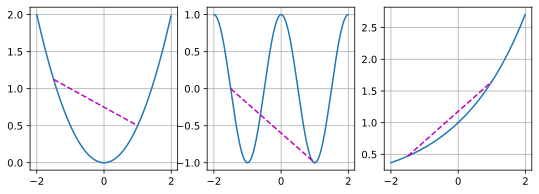

In [ ]:
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

不出所料，余弦函数为非凸的，而抛物线函数和指数函数为凸的。
请注意，为使该条件有意义，$\mathcal{X}$是凸集的要求是必要的。
否则可能无法很好地界定$f(\lambda x + (1-\lambda) x')$的结果。

### 詹森不等式

给定一个凸函数$f$，最有用的数学工具之一就是*詹森不等式*（Jensen's inequality）。
它是凸性定义的一种推广：

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right) \text{ and } E_X[f(X)] \geq f\left(E_X[X]\right),$$
:eqlabel:`eq_jensens-inequality`

其中$\alpha_i$是满足$\sum_i \alpha_i = 1$的非负实数，$X$是随机变量。
换句话说，凸函数的期望不小于期望的凸函数，其中后者通常是一个更简单的表达式。
为了证明第一个不等式，我们多次将凸性的定义应用于一次求和中的一项。

詹森不等式的一个常见应用：用一个较简单的表达式约束一个较复杂的表达式。
例如，它可以应用于部分观察到的随机变量的对数似然。
具体地说，由于$\int P(Y) P(X \mid Y) dY = P(X)$，所以

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

这里，$Y$是典型的未观察到的随机变量，$P(Y)$是它可能如何分布的最佳猜测，$P(X)$是将$Y$积分后的分布。
例如，在聚类中$Y$可能是簇标签，而在应用簇标签时，$P(X \mid Y)$是生成模型。

## 性质

下面我们来看一下凸函数一些有趣的性质。

### 局部极小值是全局极小值

首先凸函数的局部极小值也是全局极小值。
下面我们用反证法给出证明。

假设$x^{\ast} \in \mathcal{X}$是一个局部最小值，则存在一个很小的正值$p$，使得当$x \in \mathcal{X}$满足$0 < |x - x^{\ast}| \leq p$时，有$f(x^{\ast}) < f(x)$。

现在假设局部极小值$x^{\ast}$不是$f$的全局极小值：存在$x' \in \mathcal{X}$使得$f(x') < f(x^{\ast})$。
则存在
$\lambda \in [0, 1)$，比如$\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$，使得
$0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$。

然而，根据凸性的性质，有

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}), \\
\end{aligned}$$

这与$x^{\ast}$是局部最小值相矛盾。
因此，不存在$x' \in \mathcal{X}$满足$f(x') < f(x^{\ast})$。
综上所述，局部最小值$x^{\ast}$也是全局最小值。

例如，对于凸函数$f(x) = (x-1)^2$，有一个局部最小值$x=1$，它也是全局最小值。


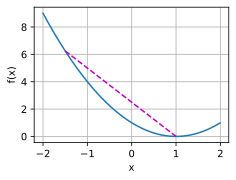

In [ ]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

凸函数的局部极小值同时也是全局极小值这一性质是很方便的。
这意味着如果我们最小化函数，我们就不会“卡住”。
但是，请注意，这并不意味着不能有多个全局最小值，或者可能不存在一个全局最小值。
例如，函数$f(x) = \mathrm{max}(|x|-1, 0)$在$[-1,1]$区间上都是最小值。
相反，函数$f(x) = \exp(x)$在$\mathbb{R}$上没有取得最小值。对于$x \to -\infty$，它趋近于$0$，但是没有$f(x) = 0$的$x$。

### 凸函数的下水平集是凸的

我们可以方便地通过凸函数的*下水平集*（below sets）定义凸集。
具体来说，给定一个定义在凸集$\mathcal{X}$上的凸函数$f$，其任意一个下水平集

$$\mathcal{S}_b := \{x | x \in \mathcal{X} \text{ and } f(x) \leq b\}$$

是凸的。

让我们快速证明一下。
对于任何$x, x' \in \mathcal{S}_b$，我们需要证明：当$\lambda \in [0, 1]$时，$\lambda x + (1-\lambda) x' \in \mathcal{S}_b$。
因为$f(x) \leq b$且$f(x') \leq b$，所以

$$f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b.$$

### 凸性和二阶导数

当一个函数的二阶导数$f: \mathbb{R}^n \rightarrow \mathbb{R}$存在时，我们很容易检查这个函数的凸性。
我们需要做的就是检查$\nabla^2f \succeq 0$，
即对于所有$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$.
例如，函数$f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$是凸的，因为$\nabla^2 f = \mathbf{1}$，即其导数是单位矩阵。

更正式地讲，$f$为凸函数，当且仅当任意二次可微一维函数$f: \mathbb{R}^n \rightarrow \mathbb{R}$是凸的。
对于任意二次可微多维函数$f: \mathbb{R}^{n} \rightarrow \mathbb{R}$，
它是凸的当且仅当它的Hessian$\nabla^2f\succeq 0$。

首先，我们来证明一下一维情况。
为了证明凸函数的$f''(x) \geq 0$，我们使用：

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

因为二阶导数是由有限差分的极限给出的，所以遵循

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$$

为了证明$f'' \geq 0$可以推导$f$是凸的，
我们使用这样一个事实：$f'' \geq 0$意味着$f'$是一个单调的非递减函数。
假设$a < x < b$是$\mathbb{R}$中的三个点，
其中，$x = (1-\lambda)a + \lambda b$且$\lambda \in (0, 1)$.
根据中值定理，存在$\alpha \in [a, x]$，$\beta \in [x, b]$，使得
$$f'(\alpha) = \frac{f(x) - f(a)}{x-a} \text{ 且 } f'(\beta) = \frac{f(b) - f(x)}{b-x}.$$

通过单调性$f'(\beta) \geq f'(\alpha)$，因此

$$\frac{x-a}{b-a}f(b) + \frac{b-x}{b-a}f(a) \geq f(x).$$

由于$x = (1-\lambda)a + \lambda b$，所以

$$\lambda f(b) + (1-\lambda)f(a) \geq f((1-\lambda)a + \lambda b),$$

从而证明了凸性。

第二，我们需要一个引理证明多维情况：
$f: \mathbb{R}^n \rightarrow \mathbb{R}$
是凸的当且仅当对于所有$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$

$$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y}) \text{ where } z \in [0,1]$$ 

是凸的。

为了证明$f$的凸性意味着$g$是凸的，
我们可以证明，对于所有的$a，b，\lambda \in[0，1]$（这样有$0 \leq \lambda a + (1-\lambda) b \leq 1$），

$$\begin{aligned} &g(\lambda a + (1-\lambda) b)\\
=&f\left(\left(\lambda a + (1-\lambda) b\right)\mathbf{x} + \left(1-\lambda a - (1-\lambda) b\right)\mathbf{y} \right)\\
=&f\left(\lambda \left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) \left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \right)\\
\leq& \lambda f\left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) f\left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \\
=& \lambda g(a) + (1-\lambda) g(b).
\end{aligned}$$

为了证明这一点，我们可以证明对
$[0，1]$中所有的$\lambda$：

$$\begin{aligned} &f(\lambda \mathbf{x} + (1-\lambda) \mathbf{y})\\
=&g(\lambda \cdot 1 + (1-\lambda) \cdot 0)\\
\leq& \lambda g(1)  + (1-\lambda) g(0) \\
=& \lambda f(\mathbf{x}) + (1-\lambda) f(\mathbf{y}).
\end{aligned}$$

最后，利用上面的引理和一维情况的结果，我们可以证明多维情况：
多维函数$f:\mathbb{R}^n\rightarrow\mathbb{R}$是凸函数，当且仅当$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y})$是凸的，这里$z \in [0,1]$，$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$。
根据一维情况，
此条成立的条件为，当且仅当对于所有$\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$，
$g'' = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{y}) \geq 0$（$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2f$）。
这相当于根据半正定矩阵的定义，$\mathbf{H} \succeq 0$。

## 约束

凸优化的一个很好的特性是能够让我们有效地处理*约束*（constraints）。
即它使我们能够解决以下形式的*约束优化*（constrained optimization）问题：

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, N\}.
\end{aligned}$$

这里$f$是目标函数，$c_i$是约束函数。
例如第一个约束$c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$，则参数$\mathbf{x}$被限制为单位球。
如果第二个约束$c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$，那么这对应于半空间上所有的$\mathbf{x}$。
同时满足这两个约束等于选择一个球的切片作为约束集。

### 拉格朗日函数

通常，求解一个有约束的优化问题是困难的，解决这个问题的一种方法来自物理中相当简单的直觉。
想象一个球在一个盒子里，球会滚到最低的地方，重力将与盒子两侧对球施加的力平衡。
简而言之，目标函数（即重力）的梯度将被约束函数的梯度所抵消（由于墙壁的“推回”作用，需要保持在盒子内）。
请注意，任何不起作用的约束（即球不接触壁）都将无法对球施加任何力。

这里我们简略拉格朗日函数$L$的推导，上述推理可以通过以下鞍点优化问题来表示：

$$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

这里的变量$\alpha_i$（$i=1,\ldots,n$）是所谓的*拉格朗日乘数*（Lagrange multipliers），它确保约束被正确地执行。
选择它们的大小足以确保所有$i$的$c_i(\mathbf{x}) \leq 0$。
例如，对于$c_i(\mathbf{x}) < 0$中任意$\mathbf{x}$，我们最终会选择$\alpha_i = 0$。
此外，这是一个*鞍点*（saddlepoint）优化问题。
在这个问题中，我们想要使$L$相对于$\alpha_i$*最大化*（maximize），同时使它相对于$\mathbf{x}$*最小化*（minimize）。
有大量的文献解释如何得出函数$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n)$。
我们这里只需要知道$L$的鞍点是原始约束优化问题的最优解就足够了。

### 惩罚

一种至少近似地满足约束优化问题的方法是采用拉格朗日函数$L$。除了满足$c_i(\mathbf{x}) \leq 0$之外，我们只需将$\alpha_i c_i(\mathbf{x})$添加到目标函数$f(x)$。
这样可以确保不会严重违反约束。

事实上，我们一直在使用这个技巧。
比如权重衰减 :numref:`sec_weight_decay`，在目标函数中加入$\frac{\lambda}{2} |\mathbf{w}|^2$，以确保$\mathbf{w}$不会增长太大。
使用约束优化的观点，我们可以看到，对于若干半径$r$，这将确保$|\mathbf{w}|^2 - r^2 \leq 0$。
通过调整$\lambda$的值，我们可以改变$\mathbf{w}$的大小。

通常，添加惩罚是确保近似满足约束的一种好方法。
在实践中，这被证明比精确的满意度更可靠。
此外，对于非凸问题，许多使精确方法在凸情况下的性质（例如，可求最优解）不再成立。

### 投影

满足约束条件的另一种策略是*投影*（projections）。
同样，我们之前也遇到过，例如在 :numref:`sec_rnn_scratch`中处理梯度截断时，我们通过

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/\|\mathbf{g}\|),$$

确保梯度的长度以$\theta$为界限。

这就是$\mathbf{g}$在半径为$\theta$的球上的*投影*（projection）。
更泛化地说，在凸集$\mathcal{X}$上的投影被定义为

$$\mathrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|.$$

它是$\mathcal{X}$中离$\mathbf{X}$最近的点。

![Convex Projections.](http://d2l.ai/_images/projections.svg)
:label:`fig_projections`

投影的数学定义听起来可能有点抽象，为了解释得更清楚一些，请看 :numref:`fig_projections`。
图中有两个凸集，一个圆和一个菱形。
两个集合内的点（黄色）在投影期间保持不变。
两个集合（黑色）之外的点投影到集合中接近原始点（黑色）的点（红色）。
虽然对于$L_2$的球面来说，方向保持不变，但一般情况下不需要这样。

凸投影的一个用途是计算稀疏权重向量。
在本例中，我们将权重向量投影到一个$L_1$的球上，
这是 :numref:`fig_projections`中菱形例子的一个广义版本。

## 小结

在深度学习的背景下，凸函数的主要目的是帮助我们详细了解优化算法。
我们由此得出梯度下降法和随机梯度下降法是如何相应推导出来的。

* 凸集的交点是凸的，并集不是。
* 根据詹森不等式，“一个多变量凸函数的总期望值”大于或等于“用每个变量的期望值计算这个函数的总值“。
* 一个二次可微函数是凸函数，当且仅当其Hessian（二阶导数矩阵）是半正定的。
* 凸约束可以通过拉格朗日函数来添加。在实践中，只需在目标函数中加上一个惩罚就可以了。
* 投影映射到凸集中最接近原始点的点。

## 练习 

1. 假设我们想要通过绘制集合内点之间的所有直线并检查这些直线是否包含来验证集合的凸性。
i.证明只检查边界上的点是充分的。
ii.证明只检查集合的顶点是充分的。
2. 用$p$-范数表示半径为$r$的球，证明$\mathcal{B}_p[r] := \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \|\mathbf{x}\|_p \leq r\}$，$\mathcal{B}_p[r]$对于所有$p \geq 1$是凸的。

3. 已知凸函数$f$和$g$表明$\mathrm{max}(f, g)$也是凸函数。证明$\mathrm{min}(f, g)$是非凸的。

4. 证明Softmax函数的规范化是凸的，即$f(x) = \log \sum_i \exp(x_i)$的凸性。

5. 证明线性子空间$\mathcal{X} = {\mathbf{X} | \mathbf{W} \mathbf{X} = \mathbf{b}}$是凸集。

6. 证明在线性子空间$\mathbf{b} = \mathbf{0}$的情况下，对于矩阵$\mathbf{M}$的投影$\mathrm {Proj} \mathcal{X}$可以写成$\mathbf{M} \mathbf{X}$。

7. 证明对于凸二次可微函数$f$，对于$\xi \in [0, \epsilon]$，我们可以写成$f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$。

8. 给定一个向量$\mathbf{w} \in \mathbb{R}^d$与$|\mathbf{w}| 1 > 1$计算在$L_1$单位球上的投影。
i.作为中间步骤，写出惩罚目标$|\mathbf{w} - \mathbf{w}'|_2^2 + \lambda |\mathbf{w}'|_1$，计算给定$\lambda > 0$的解。
ii.你能无须反复试错就找到$\lambda$的“正确”值吗？

9. 给定一个凸集$\mathcal{X}$和两个向量$\mathbf{X}$和$\mathbf{y}$证明了投影不会增加距离，即$\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_\mathcal{X}(\mathbf{x}) - \mathrm{Proj}_\mathcal{X}(\mathbf{y})\|$。


# 梯度下降
:label:`sec_gd`

尽管*梯度下降*（gradient descent）很少直接用于深度学习，
但了解它是理解下一节随机梯度下降算法的关键。
例如，由于学习率过大，优化问题可能会发散，这种现象早已在梯度下降中出现。
同样地，*预处理*（preconditioning）是梯度下降中的一种常用技术，
还被沿用到更高级的算法中。
让我们从简单的一维梯度下降开始。

## 一维梯度下降

为什么梯度下降算法可以优化目标函数？
一维中的梯度下降给我们很好的启发。
考虑一类连续可微实值函数$f: \mathbb{R} \rightarrow \mathbb{R}$，
利用泰勒展开，我们可以得到

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$
:eqlabel:`gd-taylor`

即在一阶近似中，$f(x+\epsilon)$可通过$x$处的函数值$f(x)$和一阶导数$f'(x)$得出。
我们可以假设在负梯度方向上移动的$\epsilon$会减少$f$。
为了简单起见，我们选择固定步长$\eta > 0$，然后取$\epsilon = -\eta f'(x)$。
将其代入泰勒展开式我们可以得到

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$
:eqlabel:`gd-taylor-2`

如果其导数$f'(x) \neq 0$没有消失，我们就能继续展开，这是因为$\eta f'^2(x)>0$。
此外，我们总是可以令$\eta$小到足以使高阶项变得不相关。
因此，

$$f(x - \eta f'(x)) \lessapprox f(x).$$

这意味着，如果我们使用

$$x \leftarrow x - \eta f'(x)$$

来迭代$x$，函数$f(x)$的值可能会下降。
因此，在梯度下降中，我们首先选择初始值$x$和常数$\eta > 0$，
然后使用它们连续迭代$x$，直到停止条件达成。
例如，当梯度$|f'(x)|$的幅度足够小或迭代次数达到某个值时。

下面我们来展示如何实现梯度下降。为了简单起见，我们选用目标函数$f(x)=x^2$。
尽管我们知道$x=0$时$f(x)$能取得最小值，
但我们仍然使用这个简单的函数来观察$x$的变化。


In [ ]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

In [ ]:
def f(x):  # 目标函数
    return x ** 2

def f_grad(x):  # 目标函数的梯度(导数)
    return 2 * x

接下来，我们使用$x=10$作为初始值，并假设$\eta=0.2$。
使用梯度下降法迭代$x$共10次，我们可以看到，$x$的值最终将接近最优解。


In [ ]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


对进行$x$优化的过程可以绘制如下。


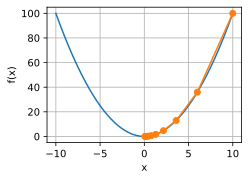

In [ ]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(results, f)

### 学习率
:label:`subsec_gd-learningrate`

*学习率*（learning rate）决定目标函数能否收敛到局部最小值，以及何时收敛到最小值。
学习率$\eta$可由算法设计者设置。
请注意，如果我们使用的学习率太小，将导致$x$的更新非常缓慢，需要更多的迭代。
例如，考虑同一优化问题中$\eta = 0.05$的进度。
如下所示，尽管经过了10个步骤，我们仍然离最优解很远。


epoch 10, x: 3.486784


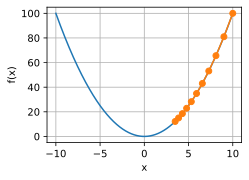

In [ ]:
show_trace(gd(0.05, f_grad), f)

相反，如果我们使用过高的学习率，$\left|\eta f'(x)\right|$对于一阶泰勒展开式可能太大。
也就是说， :eqref:`gd-taylor`中的$\mathcal{O}(\eta^2 f'^2(x))$可能变得显著了。
在这种情况下，$x$的迭代不能保证降低$f(x)$的值。
例如，当学习率为$\eta=1.1$时，$x$超出了最优解$x=0$并逐渐发散。


epoch 10, x: 61.917364


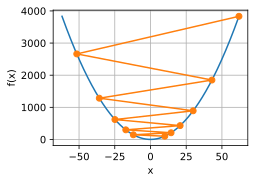

In [ ]:
show_trace(gd(1.1, f_grad), f)

### 局部最小值

为了演示非凸函数的梯度下降，考虑函数$f(x) = x \cdot \cos(cx)$，其中$c$为某常数。
这个函数有无穷多个局部最小值。
根据我们选择的学习率，我们最终可能只会得到许多解的一个。
下面的例子说明了（不切实际的）高学习率如何导致较差的局部最小值。


epoch 10, x: -1.528166


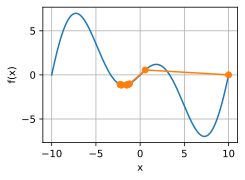

In [ ]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

## 多元梯度下降

现在我们对单变量的情况有了更好的理解，让我们考虑一下$\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$的情况。
即目标函数$f: \mathbb{R}^d \to \mathbb{R}$将向量映射成标量。
相应地，它的梯度也是多元的：它是一个由$d$个偏导数组成的向量：

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

梯度中的每个偏导数元素$\partial f(\mathbf{x})/\partial x_i$代表了当输入$x_i$时$f$在$\mathbf{x}$处的变化率。
和先前单变量的情况一样，我们可以对多变量函数使用相应的泰勒近似来思考。
具体来说，

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2).$$
:eqlabel:`gd-multi-taylor`

换句话说，在$\boldsymbol{\epsilon}$的二阶项中，
最陡下降的方向由负梯度$-\nabla f(\mathbf{x})$得出。
选择合适的学习率$\eta > 0$来生成典型的梯度下降算法：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

这个算法在实践中的表现如何呢？
我们构造一个目标函数$f(\mathbf{x})=x_1^2+2x_2^2$，
并有二维向量$\mathbf{x} = [x_1, x_2]^\top$作为输入，
标量作为输出。
梯度由$\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$给出。
我们将从初始位置$[-5, -2]$通过梯度下降观察$\mathbf{x}$的轨迹。

我们还需要两个辅助函数：
第一个是update函数，并将其应用于初始值20次；
第二个函数会显示$\mathbf{x}$的轨迹。


In [ ]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""
    # s1和s2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """显示优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

接下来，我们观察学习率$\eta = 0.1$时优化变量$\mathbf{x}$的轨迹。
可以看到，经过20步之后，$\mathbf{x}$的值接近其位于$[0, 0]$的最小值。
虽然进展相当顺利，但相当缓慢。


epoch 20, x1: -0.057646, x2: -0.000073


/home/d2l-worker/miniconda3/envs/d2l-zh-release-1/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


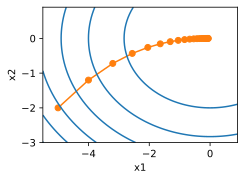

In [ ]:
def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # 目标函数的梯度
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## 自适应方法

正如我们在 :numref:`subsec_gd-learningrate`中所看到的，选择“恰到好处”的学习率$\eta$是很棘手的。
如果我们把它选得太小，就没有什么进展；如果太大，得到的解就会振荡，甚至可能发散。
如果我们可以自动确定$\eta$，或者完全不必选择学习率，会怎么样？
除了考虑目标函数的值和梯度、还考虑它的曲率的二阶方法可以帮我们解决这个问题。
虽然由于计算代价的原因，这些方法不能直接应用于深度学习，但它们为如何设计高级优化算法提供了有用的思维直觉，这些算法可以模拟下面概述的算法的许多理想特性。

### 牛顿法

回顾一些函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的泰勒展开式，事实上我们可以把它写成

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).$$
:eqlabel:`gd-hot-taylor`

为了避免繁琐的符号，我们将$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$定义为$f$的Hessian，是$d \times d$矩阵。
当$d$的值很小且问题很简单时，$\mathbf{H}$很容易计算。
但是对于深度神经网络而言，考虑到$\mathbf{H}$可能非常大，
$\mathcal{O}(d^2)$个条目的存储代价会很高，
此外通过反向传播进行计算可能雪上加霜。
然而，我们姑且先忽略这些考量，看看会得到什么算法。

毕竟，$f$的最小值满足$\nabla f = 0$。
遵循 :numref:`sec_calculus`中的微积分规则，
通过取$\boldsymbol{\epsilon}$对 :eqref:`gd-hot-taylor`的导数，
再忽略不重要的高阶项，我们便得到

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$$

也就是说，作为优化问题的一部分，我们需要将Hessian矩阵$\mathbf{H}$求逆。

举一个简单的例子，对于$f(x) = \frac{1}{2} x^2$，我们有$\nabla f(x) = x$和$\mathbf{H} = 1$。
因此，对于任何$x$，我们可以获得$\epsilon = -x$。
换言之，单单一步就足以完美地收敛，而无须任何调整。
我们在这里比较幸运：泰勒展开式是确切的，因为$f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$。

让我们看看其他问题。
给定一个凸双曲余弦函数$c$，其中$c$为某些常数，
我们可以看到经过几次迭代后，得到了$x=0$处的全局最小值。


epoch 10, x: tensor(0.)


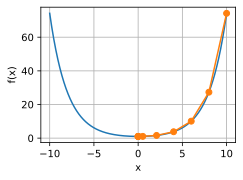

In [ ]:
c = torch.tensor(0.5)

def f(x):  # O目标函数
    return torch.cosh(c * x)

def f_grad(x):  # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

现在让我们考虑一个非凸函数，比如$f(x) = x \cos(c x)$，$c$为某些常数。
请注意在牛顿法中，我们最终将除以Hessian。
这意味着如果二阶导数是负的，$f$的值可能会趋于增加。
这是这个算法的致命缺陷！
让我们看看实践中会发生什么。


epoch 10, x: tensor(26.8341)


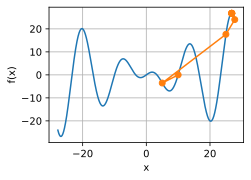

In [ ]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

这发生了惊人的错误。我们怎样才能修正它？
一种方法是用取Hessian的绝对值来修正，另一个策略是重新引入学习率。
这似乎违背了初衷，但不完全是——拥有二阶信息可以使我们在曲率较大时保持谨慎，而在目标函数较平坦时则采用较大的学习率。
让我们看看在学习率稍小的情况下它是如何生效的，比如$\eta = 0.5$。
如我们所见，我们有了一个相当高效的算法。


epoch 10, x: tensor(7.2699)


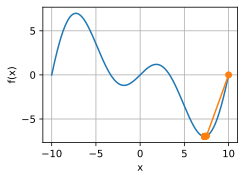

In [ ]:
show_trace(newton(0.5), f)

### 收敛性分析

在此，我们以部分目标凸函数$f$为例，分析它们的牛顿法收敛速度。
这些目标凸函数三次可微，而且二阶导数不为零，即$f'' > 0$。
由于多变量情况下的证明是对以下一维参数情况证明的直接拓展，对我们理解这个问题不能提供更多帮助，因此我们省略了多变量情况的证明。

用$x^{(k)}$表示$x$在第$k^\mathrm{th}$次迭代时的值，
令$e^{(k)} \stackrel{\mathrm{def}}{=} x^{(k)} - x^*$表示$k^\mathrm{th}$迭代时与最优性的距离。
通过泰勒展开，我们得到条件$f'(x^*) = 0$可以写成

$$0 = f'(x^{(k)} - e^{(k)}) = f'(x^{(k)}) - e^{(k)} f''(x^{(k)}) + \frac{1}{2} (e^{(k)})^2 f'''(\xi^{(k)}),$$

这对某些$\xi^{(k)} \in [x^{(k)} - e^{(k)}, x^{(k)}]$成立。
将上述展开除以$f''(x^{(k)})$得到

$$e^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})} = \frac{1}{2} (e^{(k)})^2 \frac{f'''(\xi^{(k)})}{f''(x^{(k)})}.$$

回想之前的方程$x^{(k+1)} = x^{(k)} - f'(x^{(k)}) / f''(x^{(k)})$。
代入这个更新方程，取两边的绝对值，我们得到

$$\left|e^{(k+1)}\right| = \frac{1}{2}(e^{(k)})^2 \frac{\left|f'''(\xi^{(k)})\right|}{f''(x^{(k)})}.$$

因此，每当我们处于有界区域$\left|f'''(\xi^{(k)})\right| / (2f''(x^{(k)})) \leq c$，
我们就有一个二次递减误差

$$\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.$$

另一方面，优化研究人员称之为“线性”收敛，而将$\left|e^{(k+1)}\right| \leq \alpha \left|e^{(k)}\right|$这样的条件称为“恒定”收敛速度。
请注意，我们无法估计整体收敛的速度，但是一旦我们接近极小值，收敛将变得非常快。
另外，这种分析要求$f$在高阶导数上表现良好，即确保$f$在如何变化它的值方面没有任何“超常”的特性。

### 预处理

计算和存储完整的Hessian非常昂贵，而改善这个问题的一种方法是“预处理”。
它回避了计算整个Hessian，而只计算“对角线”项，即如下的算法更新：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).$$

虽然这不如完整的牛顿法精确，但它仍然比不使用要好得多。
为什么预处理有效呢？
假设一个变量以毫米表示高度，另一个变量以公里表示高度的情况。
假设这两种自然尺度都以米为单位，那么我们的参数化就出现了严重的不匹配。
幸运的是，使用预处理可以消除这种情况。
梯度下降的有效预处理相当于为每个变量选择不同的学习率（矢量$\mathbf{x}$的坐标）。
我们将在后面一节看到，预处理推动了随机梯度下降优化算法的一些创新。

### 梯度下降和线搜索

梯度下降的一个关键问题是我们可能会超过目标或进展不足，
解决这一问题的简单方法是结合使用线搜索和梯度下降。
也就是说，我们使用$\nabla f(\mathbf{x})$给出的方向，
然后进行二分搜索，以确定哪个学习率$\eta$使$f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$取最小值。

有关分析和证明，此算法收敛迅速（请参见 :cite:`Boyd.Vandenberghe.2004`）。
然而，对深度学习而言，这不太可行。
因为线搜索的每一步都需要评估整个数据集上的目标函数，实现它的方式太昂贵了。

## 小结

* 学习率的大小很重要：学习率太大会使模型发散，学习率太小会没有进展。
* 梯度下降会可能陷入局部极小值，而得不到全局最小值。
* 在高维模型中，调整学习率是很复杂的。
* 预处理有助于调节比例。
* 牛顿法在凸问题中一旦开始正常工作，速度就会快得多。
* 对于非凸问题，不要不作任何调整就使用牛顿法。

## 练习

1. 用不同的学习率和目标函数进行梯度下降实验。
1. 在区间$[a, b]$中实现线搜索以最小化凸函数。
    1. 你是否需要导数来进行二分搜索，即决定选择$[a, (a+b)/2]$还是$[(a+b)/2, b]$。
    1. 算法的收敛速度有多快？
    1. 实现该算法，并将其应用于求$\log (\exp(x) + \exp(-2x -3))$的最小值。
1. 设计一个定义在$\mathbb{R}^2$上的目标函数，它的梯度下降非常缓慢。提示：不同坐标的缩放方式不同。
1. 使用预处理实现牛顿方法的轻量级版本：
    1. 使用对角Hessian作为预条件。
    1. 使用它的绝对值，而不是实际值（可能有符号）。
    1. 将此应用于上述问题。
1. 将上述算法应用于多个目标函数（凸或非凸）。如果你把坐标旋转$45$度会怎么样？


# 随机梯度下降
:label:`sec_sgd`

但是，在前面的章节中，我们一直在训练过程中使用随机梯度下降，但没有解释它为什么起作用。为了澄清这一点，我们刚在 :numref:`sec_gd`中描述了梯度下降的基本原则。在本节中，我们继续更详细地说明*随机梯度下降*（stochastic gradient descent）。


In [ ]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

## 随机梯度更新

在深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值。给定$n$个样本的训练数据集，我们假设$f_i(\mathbf{x})$是关于索引$i$的训练样本的损失函数，其中$\mathbf{x}$是参数向量。然后我们得到目标函数

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

$\mathbf{x}$的目标函数的梯度计算为

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

如果使用梯度下降法，则每个自变量迭代的计算代价为$\mathcal{O}(n)$，它随$n$线性增长。因此，当训练数据集较大时，每次迭代的梯度下降计算代价将较高。

随机梯度下降（SGD）可降低每次迭代时的计算代价。在随机梯度下降的每次迭代中，我们对数据样本随机均匀采样一个索引$i$，其中$i\in\{1,\ldots, n\}$，并计算梯度$\nabla f_i(\mathbf{x})$以更新$\mathbf{x}$：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

其中$\eta$是学习率。我们可以看到，每次迭代的计算代价从梯度下降的$\mathcal{O}(n)$降至常数$\mathcal{O}(1)$。此外，我们要强调，随机梯度$\nabla f_i(\mathbf{x})$是对完整梯度$\nabla f(\mathbf{x})$的无偏估计，因为

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

这意味着，平均而言，随机梯度是对梯度的良好估计。

现在，我们将把它与梯度下降进行比较，方法是向梯度添加均值为0、方差为1的随机噪声，以模拟随机梯度下降。


In [ ]:
def f(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # 目标函数的梯度
    return 2 * x1, 4 * x2

In [ ]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: -0.156651, x2: 0.032314


/home/d2l-worker/miniconda3/envs/d2l-zh-release-1/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/home/d2l-worker/miniconda3/envs/d2l-zh-release-1/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


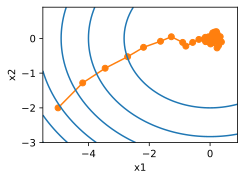

In [ ]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # 常数学习速度
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

正如我们所看到的，随机梯度下降中变量的轨迹比我们在 :numref:`sec_gd`中观察到的梯度下降中观察到的轨迹嘈杂得多。这是由于梯度的随机性质。也就是说，即使我们接近最小值，我们仍然受到通过$\eta \nabla f_i(\mathbf{x})$的瞬间梯度所注入的不确定性的影响。即使经过50次迭代，质量仍然不那么好。更糟糕的是，经过额外的步骤，它不会得到改善（我们鼓励你尝试更多的步骤来确认这一点）。这给我们留下了唯一的选择：改变学习率$\eta$。但是，如果我们选择的学习率太小，我们一开始就不会取得任何有意义的进展。另一方面，如果我们选择的学习率太大，我们将无法获得一个好的解决方案，如上所示。解决这些相互冲突的目标的唯一方法是在优化过程中*动态*降低学习率。

这也是在`sgd`步长函数中添加学习率函数`lr`的原因。在上面的示例中，学习率调度的任何功能都处于休眠状态，因为我们将相关的`lr`函数设置为常量。

## 动态学习率

用与时间相关的学习率$\eta(t)$取代$\eta$增加了控制优化算法收敛的复杂性。特别是，我们需要弄清$\eta$的衰减速度。如果太快，我们将过早停止优化。如果减少的太慢，我们会在优化上浪费太多时间。以下是随着时间推移调整$\eta$时使用的一些基本策略（稍后我们将讨论更高级的策略）：

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{分段常数} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \text{指数衰减} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{多项式衰减}
\end{aligned}
$$

在第一个*分段常数*（piecewise constant）场景中，我们会降低学习率，例如，每当优化进度停顿时。这是训练深度网络的常见策略。或者，我们可以通过*指数衰减*（exponential decay）来更积极地减低它。不幸的是，这往往会导致算法收敛之前过早停止。一个受欢迎的选择是$\alpha = 0.5$的*多项式衰减*（polynomial decay）。在凸优化的情况下，有许多证据表明这种速率表现良好。

让我们看看指数衰减在实践中是什么样子。


epoch 1000, x1: -0.758366, x2: -0.054091


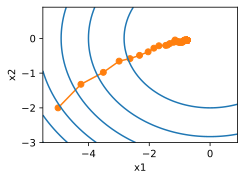

In [ ]:
def exponential_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

正如预期的那样，参数的方差大大减少。但是，这是以未能收敛到最优解$\mathbf{x} = (0, 0)$为代价的。即使经过1000个迭代步骤，我们仍然离最优解很远。事实上，该算法根本无法收敛。另一方面，如果我们使用多项式衰减，其中学习率随迭代次数的平方根倒数衰减，那么仅在50次迭代之后，收敛就会更好。


epoch 50, x1: -0.079826, x2: -0.014203


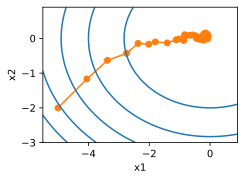

In [ ]:
def polynomial_lr():
    # 在函数外部定义，而在内部更新的全局变量
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

关于如何设置学习率，还有更多的选择。例如，我们可以从较小的学习率开始，然后使其迅速上涨，再让它降低，尽管这会更慢。我们甚至可以在较小和较大的学习率之间切换。这样的计划各种各样。现在，让我们专注于可以进行全面理论分析的学习率计划，即凸环境下的学习率。对于一般的非凸问题，很难获得有意义的收敛保证，因为总的来说，最大限度地减少非线性非凸问题是NP困难的。有关的研究调查，请参阅例如2015年Tibshirani的优秀[讲义笔记](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf)。

## 凸目标的收敛性分析

以下对凸目标函数的随机梯度下降的收敛性分析是可选的，主要用于传达对问题的更多直觉。我们只限于最简单的证明之一 :cite:`Nesterov.Vial.2000`。存在着明显更先进的证明技术，例如，当目标函数表现特别好时。

假设所有$\boldsymbol{\xi}$的目标函数$f(\boldsymbol{\xi}, \mathbf{x})$在$\mathbf{x}$中都是凸的。更具体地说，我们考虑随机梯度下降更新：

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}),$$

其中$f(\boldsymbol{\xi}_t, \mathbf{x})$是训练样本$f(\boldsymbol{\xi}_t, \mathbf{x})$的目标函数：$\boldsymbol{\xi}_t$从第$t$步的某个分布中提取，$\mathbf{x}$是模型参数。用

$$R(\mathbf{x}) = E_{\boldsymbol{\xi}}[f(\boldsymbol{\xi}, \mathbf{x})]$$

表示期望风险，$R^*$表示对于$\mathbf{x}$的最低风险。最后让$\mathbf{x}^*$表示最小值（我们假设它存在于定义$\mathbf{x}$的域中）。在这种情况下，我们可以跟踪时间$t$处的当前参数$\mathbf{x}_t$和风险最小化器$\mathbf{x}^*$之间的距离，看看它是否随着时间的推移而改善：

$$\begin{aligned}    &\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \\ =& \|\mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}) - \mathbf{x}^*\|^2 \\    =& \|\mathbf{x}_{t} - \mathbf{x}^*\|^2 + \eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 - 2 \eta_t    \left\langle \mathbf{x}_t - \mathbf{x}^*, \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\right\rangle.   \end{aligned}$$
:eqlabel:`eq_sgd-xt+1-xstar`

我们假设随机梯度$\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})$的$L_2$范数受到某个常数$L$的限制，因此我们有

$$\eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 \leq \eta_t^2 L^2.$$
:eqlabel:`eq_sgd-L`

我们最感兴趣的是$\mathbf{x}_t$和$\mathbf{x}^*$之间的距离如何变化的*期望*。事实上，对于任何具体的步骤序列，距离可能会增加，这取决于我们遇到的$\boldsymbol{\xi}_t$。因此我们需要点积的边界。因为对于任何凸函数$f$，所有$\mathbf{x}$和$\mathbf{y}$都满足$f(\mathbf{y}) \geq f(\mathbf{x}) + \langle f'(\mathbf{x}), \mathbf{y} - \mathbf{x} \rangle$，按凸性我们有

$$f(\boldsymbol{\xi}_t, \mathbf{x}^*) \geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle.$$
:eqlabel:`eq_sgd-f-xi-xstar`

将不等式 :eqref:`eq_sgd-L`和 :eqref:`eq_sgd-f-xi-xstar`代入 :eqref:`eq_sgd-xt+1-xstar`我们在时间$t+1$时获得参数之间距离的边界，如下所示：

$$\|\mathbf{x}_{t} - \mathbf{x}^*\|^2 - \|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \geq 2 \eta_t (f(\boldsymbol{\xi}_t, \mathbf{x}_t) - f(\boldsymbol{\xi}_t, \mathbf{x}^*)) - \eta_t^2 L^2.$$
:eqlabel:`eqref_sgd-xt-diff`

这意味着，只要当前损失和最优损失之间的差异超过$\eta_t L^2/2$，我们就会取得进展。由于这种差异必然会收敛到零，因此学习率$\eta_t$也需要*消失*。

接下来，我们根据 :eqref:`eqref_sgd-xt-diff`取期望。得到

$$E\left[\|\mathbf{x}_{t} - \mathbf{x}^*\|^2\right] - E\left[\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2\right] \geq 2 \eta_t [E[R(\mathbf{x}_t)] - R^*] -  \eta_t^2 L^2.$$

最后一步是对$t \in \{1, \ldots, T\}$的不等式求和。在求和过程中抵消中间项，然后舍去低阶项，可以得到

$$\|\mathbf{x}_1 - \mathbf{x}^*\|^2 \geq 2 \left (\sum_{t=1}^T   \eta_t \right) [E[R(\mathbf{x}_t)] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.$$
:eqlabel:`eq_sgd-x1-xstar`

请注意，我们利用了给定的$\mathbf{x}_1$，因而可以去掉期望。最后定义

$$\bar{\mathbf{x}} \stackrel{\mathrm{def}}{=} \frac{\sum_{t=1}^T \eta_t \mathbf{x}_t}{\sum_{t=1}^T \eta_t}.$$

因为有

$$E\left(\frac{\sum_{t=1}^T \eta_t R(\mathbf{x}_t)}{\sum_{t=1}^T \eta_t}\right) = \frac{\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)]}{\sum_{t=1}^T \eta_t} = E[R(\mathbf{x}_t)],$$

根据詹森不等式（令 :eqref:`eq_jensens-inequality`中$i=t$，$\alpha_i = \eta_t/\sum_{t=1}^T \eta_t$）和$R$的凸性使其满足的$E[R(\mathbf{x}_t)] \geq E[R(\bar{\mathbf{x}})]$，因此，

$$\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)] \geq \sum_{t=1}^T \eta_t  E\left[R(\bar{\mathbf{x}})\right].$$

将其代入不等式 :eqref:`eq_sgd-x1-xstar`得到边界

$$
\left[E[\bar{\mathbf{x}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t},
$$

其中$r^2 \stackrel{\mathrm{def}}{=} \|\mathbf{x}_1 - \mathbf{x}^*\|^2$是初始选择参数与最终结果之间距离的边界。简而言之，收敛速度取决于随机梯度标准的限制方式（$L$）以及初始参数值与最优结果的距离（$r$）。请注意，边界由$\bar{\mathbf{x}}$而不是$\mathbf{x}_T$表示。因为$\bar{\mathbf{x}}$是优化路径的平滑版本。只要知道$r, L$和$T$，我们就可以选择学习率$\eta = r/(L \sqrt{T})$。这个就是上界$rL/\sqrt{T}$。也就是说，我们将按照速度$\mathcal{O}(1/\sqrt{T})$收敛到最优解。

## 随机梯度和有限样本

到目前为止，在谈论随机梯度下降时，我们进行得有点快而松散。我们假设从分布$p(x, y)$中采样得到样本$x_i$（通常带有标签$y_i$），并且用它来以某种方式更新模型参数。特别是，对于有限的样本数量，我们仅仅讨论了由某些允许我们在其上执行随机梯度下降的函数$\delta_{x_i}$和$\delta_{y_i}$组成的离散分布$p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$。

但是，这不是我们真正做的。在本节的简单示例中，我们只是将噪声添加到其他非随机梯度上，也就是说，我们假装有成对的$(x_i, y_i)$。事实证明，这种做法在这里是合理的（有关详细讨论，请参阅练习）。更麻烦的是，在以前的所有讨论中，我们显然没有这样做。相反，我们遍历了所有实例*恰好一次*。要了解为什么这更可取，可以反向考虑一下，即我们*有替换地*从离散分布中采样$n$个观测值。随机选择一个元素$i$的概率是$1/n$。因此选择它*至少*一次就是

$$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-1/n)^n \approx 1-e^{-1} \approx 0.63.$$

类似的推理表明，挑选一些样本（即训练示例）*恰好一次*的概率是

$${n \choose 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \left(1-\frac{1}{n}\right)^{n} \approx e^{-1} \approx 0.37.$$

这导致与*无替换*采样相比，方差增加并且数据效率降低。因此，在实践中我们执行后者（这是本书中的默认选择）。最后一点注意，重复采用训练数据集的时候，会以*不同的*随机顺序遍历它。

## 小结

* 对于凸问题，我们可以证明，对于广泛的学习率选择，随机梯度下降将收敛到最优解。
* 对于深度学习而言，情况通常并非如此。但是，对凸问题的分析使我们能够深入了解如何进行优化，即逐步降低学习率，尽管不是太快。
* 如果学习率太小或太大，就会出现问题。实际上，通常只有经过多次实验后才能找到合适的学习率。
* 当训练数据集中有更多样本时，计算梯度下降的每次迭代的代价更高，因此在这些情况下，首选随机梯度下降。
* 随机梯度下降的最优性保证在非凸情况下一般不可用，因为需要检查的局部最小值的数量可能是指数级的。

## 练习

1. 尝试不同的随机梯度下降学习率计划和不同的迭代次数进行实验。特别是，根据迭代次数的函数来绘制与最优解$(0, 0)$的距离。
1. 证明对于函数$f(x_1, x_2) = x_1^2 + 2 x_2^2$而言，向梯度添加正态噪声等同于最小化损失函数$f(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$，其中$\mathbf{x}$是从正态分布中提取的。
1. 当你从$\{(x_1, y_1), \ldots, (x_n, y_n)\}$分别使用替换方法以及不替换方法进行采样时，比较随机梯度下降的收敛性。
1. 如果某些梯度（或者更确切地说与之相关的某些坐标）始终比所有其他梯度都大，你将如何更改随机梯度下降求解器？
1. 假设$f(x) = x^2 (1 + \sin x)$。$f$有多少局部最小值？你能改变$f$以尽量减少它需要评估所有局部最小值的方式吗？


# 小批量随机梯度下降
:label:`sec_minibatch_sgd`

到目前为止，我们在基于梯度的学习方法中遇到了两个极端情况：
 :numref:`sec_gd`中使用完整数据集来计算梯度并更新参数，
 :numref:`sec_sgd`中一次处理一个训练样本来取得进展。
二者各有利弊：每当数据非常相似时，梯度下降并不是非常“数据高效”。
而由于CPU和GPU无法充分利用向量化，随机梯度下降并不特别“计算高效”。
这暗示了两者之间可能有折中方案，这便涉及到*小批量随机梯度下降*（minibatch gradient descent）。

## 向量化和缓存

使用小批量的决策的核心是计算效率。
当考虑与多个GPU和多台服务器并行处理时，这一点最容易被理解。在这种情况下，我们需要向每个GPU发送至少一张图像。
有了每台服务器8个GPU和16台服务器，我们就能得到大小为128的小批量。

当涉及到单个GPU甚至CPU时，事情会更微妙一些：
这些设备有多种类型的内存、通常情况下多种类型的计算单元以及在它们之间不同的带宽限制。
例如，一个CPU有少量寄存器（register），L1和L2缓存，以及L3缓存（在不同的处理器内核之间共享）。
随着缓存的大小的增加，它们的延迟也在增加，同时带宽在减少。
可以说，处理器能够执行的操作远比主内存接口所能提供的多得多。

首先，具有16个内核和AVX-512向量化的2GHz CPU每秒可处理高达$2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$个字节。
同时，GPU的性能很容易超过该数字100倍。
而另一方面，中端服务器处理器的带宽可能不超过100Gb/s，即不到处理器满负荷所需的十分之一。
更糟糕的是，并非所有的内存入口都是相等的：内存接口通常为64位或更宽（例如，在最多384位的GPU上）。
因此读取单个字节会导致由于更宽的存取而产生的代价。

其次，第一次存取的额外开销很大，而按序存取（sequential access）或突发读取（burst read）相对开销较小。
有关更深入的讨论，请参阅此[维基百科文章](https://en.wikipedia.org/wiki/Cache_hierarchy)。

减轻这些限制的方法是使用足够快的CPU缓存层次结构来为处理器提供数据。
这是深度学习中批量处理背后的推动力。
举一个简单的例子：矩阵-矩阵乘法。
比如$\mathbf{A} = \mathbf{B}\mathbf{C}$，我们有很多方法来计算$\mathbf{A}$。例如，我们可以尝试以下方法：

1. 我们可以计算$\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$，也就是说，我们可以通过点积进行逐元素计算。
1. 我们可以计算$\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$，也就是说，我们可以一次计算一列。同样，我们可以一次计算$\mathbf{A}$一行$\mathbf{A}_{i,:}$。
1. 我们可以简单地计算$\mathbf{A} = \mathbf{B} \mathbf{C}$。
1. 我们可以将$\mathbf{B}$和$\mathbf{C}$分成较小的区块矩阵，然后一次计算$\mathbf{A}$的一个区块。

如果我们使用第一个选择，每次我们计算一个元素$\mathbf{A}_{ij}$时，都需要将一行和一列向量复制到CPU中。
更糟糕的是，由于矩阵元素是按顺序对齐的，因此当从内存中读取它们时，我们需要访问两个向量中许多不相交的位置。
第二种选择相对更有利：我们能够在遍历$\mathbf{B}$的同时，将列向量$\mathbf{C}_{:,j}$保留在CPU缓存中。
它将内存带宽需求减半，相应地提高了访问速度。
第三种选择表面上是最可取的，然而大多数矩阵可能不能完全放入缓存中。
第四种选择提供了一个实践上很有用的方案：我们可以将矩阵的区块移到缓存中然后在本地将它们相乘。
让我们来看看这些操作在实践中的效率如何。

除了计算效率之外，Python和深度学习框架本身带来的额外开销也是相当大的。
回想一下，每次我们执行代码时，Python解释器都会向深度学习框架发送一个命令，要求将其插入到计算图中并在调度过程中处理它。
这样的额外开销可能是非常不利的。
总而言之，我们最好用向量化（和矩阵）。


In [ ]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

按元素分配只需遍历分别为$\mathbf{B}$和$\mathbf{C}$的所有行和列，即可将该值分配给$\mathbf{A}$。


In [ ]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.0449235439300537

更快的策略是执行按列分配。


In [ ]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.0074384212493896484

最有效的方法是在一个区块中执行整个操作。让我们看看它们各自的操作速度是多少。


In [ ]:
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 1.914, column 268.874, full 3200.537


## 小批量

:label:`sec_minibatches`

之前我们会理所当然地读取数据的*小批量*，而不是观测单个数据来更新参数，现在简要解释一下原因。
处理单个观测值需要我们执行许多单一矩阵-矢量（甚至矢量-矢量）乘法，这耗费相当大，而且对应深度学习框架也要巨大的开销。
这既适用于计算梯度以更新参数时，也适用于用神经网络预测。
也就是说，每当我们执行$\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$时，消耗巨大。其中

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w}).$$

我们可以通过将其应用于一个小批量观测值来提高此操作的*计算*效率。
也就是说，我们将梯度$\mathbf{g}_t$替换为一个小批量而不是单个观测值

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}).$$

让我们看看这对$\mathbf{g}_t$的统计属性有什么影响：由于$\mathbf{x}_t$和小批量$\mathcal{B}_t$的所有元素都是从训练集中随机抽出的，因此梯度的期望保持不变。
另一方面，方差显著降低。
由于小批量梯度由正在被平均计算的$b := |\mathcal{B}_t|$个独立梯度组成，其标准差降低了$b^{-\frac{1}{2}}$。
这本身就是一件好事，因为这意味着更新与完整的梯度更接近了。

直观来说，这表明选择大型的小批量$\mathcal{B}_t$将是普遍可行的。
然而，经过一段时间后，与计算代价的线性增长相比，标准差的额外减少是微乎其微的。
在实践中我们选择一个足够大的小批量，它可以提供良好的计算效率同时仍适合GPU的内存。
下面，我们来看看这些高效的代码。
在里面我们执行相同的矩阵-矩阵乘法，但是这次我们将其一次性分为64列的“小批量”。


In [ ]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 1617.237


显而易见，小批量上的计算基本上与完整矩阵一样有效。
需要注意的是，在 :numref:`sec_batch_norm`中，我们使用了一种在很大程度上取决于小批量中的方差的正则化。
随着后者增加，方差会减少，随之而来的是批量规范化带来的噪声注入的好处。
关于实例，请参阅 :cite:`Ioffe.2017`，了解有关如何重新缩放并计算适当项目。

## 读取数据集

让我们来看看如何从数据中有效地生成小批量。
下面我们使用NASA开发的测试机翼的数据集[不同飞行器产生的噪声](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)来比较这些优化算法。
为方便起见，我们只使用前$1,500$样本。
数据已作预处理：我们移除了均值并将方差重新缩放到每个坐标为$1$。


In [ ]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

## 从零开始实现

 :numref:`sec_linear_scratch`一节中已经实现过小批量随机梯度下降算法。
我们在这里将它的输入参数变得更加通用，主要是为了方便本章后面介绍的其他优化算法也可以使用同样的输入。
具体来说，我们添加了一个状态输入`states`并将超参数放在字典`hyperparams`中。
此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法中的梯度不需要除以批量大小。


In [ ]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。
它初始化了一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。


In [ ]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

让我们来看看批量梯度下降的优化是如何进行的。
这可以通过将小批量设置为1500（即样本总数）来实现。
因此，模型参数每个迭代轮数只迭代一次。


loss: 0.249, 0.034 sec/epoch


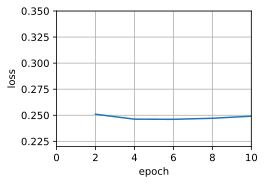

In [ ]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

当批量大小为1时，优化使用的是随机梯度下降。
为了简化实现，我们选择了很小的学习率。
在随机梯度下降的实验中，每当一个样本被处理，模型参数都会更新。
在这个例子中，这相当于每个迭代轮数有1500次更新。
可以看到，目标函数值的下降在1个迭代轮数后就变得较为平缓。
尽管两个例子在一个迭代轮数内都处理了1500个样本，但实验中随机梯度下降的一个迭代轮数耗时更多。
这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。


loss: 0.250, 0.079 sec/epoch


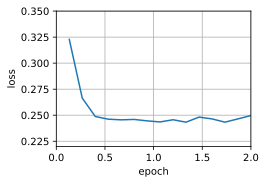

In [ ]:
sgd_res = train_sgd(0.005, 1)

最后，当批量大小等于100时，我们使用小批量随机梯度下降进行优化。
每个迭代轮数所需的时间比随机梯度下降和批量梯度下降所需的时间短。


loss: 0.243, 0.003 sec/epoch


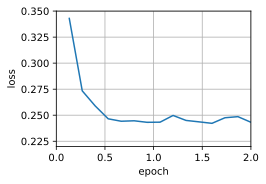

In [ ]:
mini1_res = train_sgd(.4, 100)

将批量大小减少到10，每个迭代轮数的时间都会增加，因为每批工作负载的执行效率变得更低。


loss: 0.248, 0.010 sec/epoch


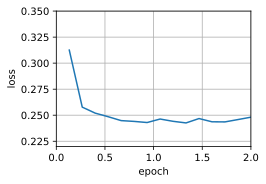

In [ ]:
mini2_res = train_sgd(.05, 10)

现在我们可以比较前四个实验的时间与损失。
可以看出，尽管在处理的样本数方面，随机梯度下降的收敛速度快于梯度下降，但与梯度下降相比，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不那么有效。
小批量随机梯度下降能够平衡收敛速度和计算效率。
大小为10的小批量比随机梯度下降更有效；
大小为100的小批量在运行时间上甚至优于梯度下降。


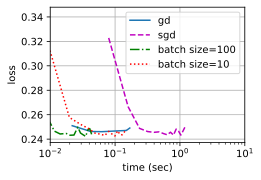

In [ ]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

## 简洁实现

下面用深度学习框架自带算法实现一个通用的训练函数，我们将在本章中其它小节使用它。


In [ ]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

下面使用这个训练函数，复现之前的实验。


loss: 0.242, 0.011 sec/epoch


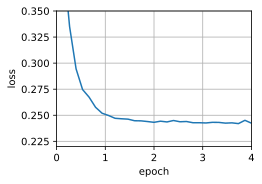

In [ ]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 小结

* 由于减少了深度学习框架的额外开销，使用更好的内存定位以及CPU和GPU上的缓存，向量化使代码更加高效。
* 随机梯度下降的“统计效率”与大批量一次处理数据的“计算效率”之间存在权衡。小批量随机梯度下降提供了两全其美的答案：计算和统计效率。
* 在小批量随机梯度下降中，我们处理通过训练数据的随机排列获得的批量数据（即每个观测值只处理一次，但按随机顺序）。
* 在训练期间降低学习率有助于训练。
* 一般来说，小批量随机梯度下降比随机梯度下降和梯度下降的速度快，收敛风险较小。

## 练习

1. 修改批量大小和学习率，并观察目标函数值的下降率以及每个迭代轮数消耗的时间。
1. 将小批量随机梯度下降与实际从训练集中*取样替换*的变体进行比较。会看出什么？
1. 一个邪恶的精灵在没通知你的情况下复制了你的数据集（即每个观测发生两次，你的数据集增加到原始大小的两倍，但没有人告诉你）。随机梯度下降、小批量随机梯度下降和梯度下降的表现将如何变化？


# 动量法
:label:`sec_momentum`

在 :numref:`sec_sgd`一节中，我们详述了如何执行随机梯度下降，即在只有嘈杂的梯度可用的情况下执行优化时会发生什么。
对于嘈杂的梯度，我们在选择学习率需要格外谨慎。
如果衰减速度太快，收敛就会停滞。
相反，如果太宽松，我们可能无法收敛到最优解。

## 基础

在本节中，我们将探讨更有效的优化算法，尤其是针对实验中常见的某些类型的优化问题。

### 泄漏平均值

上一节中我们讨论了小批量随机梯度下降作为加速计算的手段。
它也有很好的副作用，即平均梯度减小了方差。
小批量随机梯度下降可以通过以下方式计算：

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

为了保持记法简单，在这里我们使用$\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$作为样本$i$的随机梯度下降，使用时间$t-1$时更新的权重$t-1$。
如果我们能够从方差减少的影响中受益，甚至超过小批量上的梯度平均值，那很不错。
完成这项任务的一种选择是用*泄漏平均值*（leaky average）取代梯度计算：

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

其中$\beta \in (0, 1)$。
这有效地将瞬时梯度替换为多个“过去”梯度的平均值。
$\mathbf{v}$被称为*动量*（momentum），
它累加了过去的梯度。
为了更详细地解释，让我们递归地将$\mathbf{v}_t$扩展到

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

其中，较大的$\beta$相当于长期平均值，而较小的$\beta$相对于梯度法只是略有修正。
新的梯度替换不再指向特定实例下降最陡的方向，而是指向过去梯度的加权平均值的方向。
这使我们能够实现对单批量计算平均值的大部分好处，而不产生实际计算其梯度的代价。

上述推理构成了"加速"梯度方法的基础，例如具有动量的梯度。
在优化问题条件不佳的情况下（例如，有些方向的进展比其他方向慢得多，类似狭窄的峡谷），"加速"梯度还额外享受更有效的好处。
此外，它们允许我们对随后的梯度计算平均值，以获得更稳定的下降方向。
诚然，即使是对于无噪声凸问题，加速度这方面也是动量如此起效的关键原因之一。

正如人们所期望的，由于其功效，动量是深度学习及其后优化中一个深入研究的主题。
例如，请参阅[文章](https://distill.pub/2017/momentum/）（作者是 :cite:`Goh.2017`)，观看深入分析和互动动画。
动量是由 :cite:`Polyak.1964`提出的。
 :cite:`Nesterov.2018`在凸优化的背景下进行了详细的理论讨论。
长期以来，深度学习的动量一直被认为是有益的。
有关实例的详细信息，请参阅 :cite:`Sutskever.Martens.Dahl.ea.2013`的讨论。

### 条件不佳的问题

为了更好地了解动量法的几何属性，我们复习一下梯度下降，尽管它的目标函数明显不那么令人愉快。
回想我们在 :numref:`sec_gd`中使用了$f(\mathbf{x}) = x_1^2 + 2 x_2^2$，即中度扭曲的椭球目标。
我们通过向$x_1$方向伸展它来进一步扭曲这个函数

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

与之前一样，$f$在$(0, 0)$有最小值，
该函数在$x_1$的方向上*非常*平坦。
让我们看看在这个新函数上执行梯度下降时会发生什么。


epoch 20, x1: -0.943467, x2: -0.000073


/home/d2l-worker/miniconda3/envs/d2l-zh-release-1/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


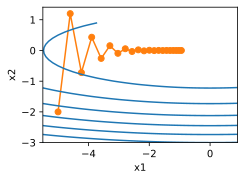

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

从构造来看，$x_2$方向的梯度比水平$x_1$方向的梯度大得多，变化也快得多。
因此，我们陷入两难：如果选择较小的学习率，我们会确保解不会在$x_2$方向发散，但要承受在$x_1$方向的缓慢收敛。相反，如果学习率较高，我们在$x_1$方向上进展很快，但在$x_2$方向将会发散。
下面的例子说明了即使学习率从$0.4$略微提高到$0.6$，也会发生变化。
$x_1$方向上的收敛有所改善，但整体来看解的质量更差了。


epoch 20, x1: -0.387814, x2: -1673.365109


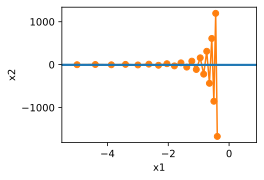

In [ ]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 动量法

*动量法*（momentum）使我们能够解决上面描述的梯度下降问题。
观察上面的优化轨迹，我们可能会直觉到计算过去的平均梯度效果会很好。
毕竟，在$x_1$方向上，这将聚合非常对齐的梯度，从而增加我们在每一步中覆盖的距离。
相反，在梯度振荡的$x_2$方向，由于相互抵消了对方的振荡，聚合梯度将减小步长大小。
使用$\mathbf{v}_t$而不是梯度$\mathbf{g}_t$可以生成以下更新等式：

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

请注意，对于$\beta = 0$，我们恢复常规的梯度下降。
在深入研究它的数学属性之前，让我们快速看一下算法在实验中的表现如何。


epoch 20, x1: 0.007188, x2: 0.002553


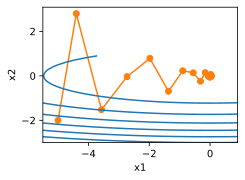

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

正如所见，尽管学习率与我们以前使用的相同，动量法仍然很好地收敛了。
让我们看看当降低动量参数时会发生什么。
将其减半至$\beta = 0.25$会导致一条几乎没有收敛的轨迹。
尽管如此，它比没有动量时解将会发散要好得多。


epoch 20, x1: -0.126340, x2: -0.186632


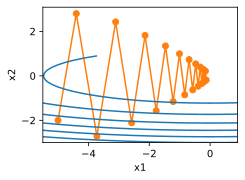

In [ ]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

请注意，我们可以将动量法与随机梯度下降，特别是小批量随机梯度下降结合起来。
唯一的变化是，在这种情况下，我们将梯度$\mathbf{g}_{t, t-1}$替换为$\mathbf{g}_t$。
为了方便起见，我们在时间$t=0$初始化$\mathbf{v}_0 = 0$。

### 有效样本权重

回想一下$\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$。
极限条件下，$\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$。
换句话说，不同于在梯度下降或者随机梯度下降中取步长$\eta$，我们选取步长$\frac{\eta}{1-\beta}$，同时处理潜在表现可能会更好的下降方向。
这是集两种好处于一身的做法。
为了说明$\beta$的不同选择的权重效果如何，请参考下面的图表。


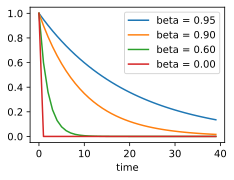

In [ ]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

## 实际实验

让我们来看看动量法在实验中是如何运作的。
为此，我们需要一个更加可扩展的实现。

### 从零开始实现

相比于小批量随机梯度下降，动量方法需要维护一组辅助变量，即速度。
它与梯度以及优化问题的变量具有相同的形状。
在下面的实现中，我们称这些变量为`states`。


In [ ]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [ ]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

让我们看看它在实验中是如何运作的。


loss: 0.245, 0.011 sec/epoch


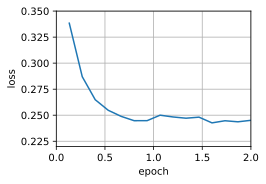

In [ ]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

当我们将动量超参数`momentum`增加到0.9时，它相当于有效样本数量增加到$\frac{1}{1 - 0.9} = 10$。
我们将学习率略微降至$0.01$，以确保可控。


loss: 0.246, 0.012 sec/epoch


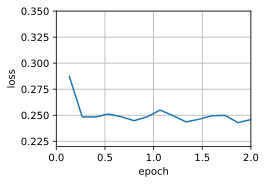

In [ ]:
train_momentum(0.01, 0.9)

降低学习率进一步解决了任何非平滑优化问题的困难，将其设置为$0.005$会产生良好的收敛性能。


loss: 0.243, 0.014 sec/epoch


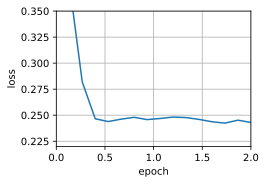

In [ ]:
train_momentum(0.005, 0.9)

### 简洁实现

由于深度学习框架中的优化求解器早已构建了动量法，设置匹配参数会产生非常类似的轨迹。


loss: 0.249, 0.012 sec/epoch


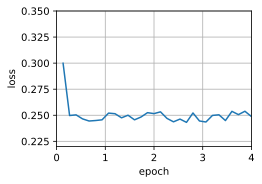

In [ ]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## 理论分析

$f(x) = 0.1 x_1^2 + 2 x_2^2$的2D示例似乎相当牵强。
下面我们将看到，它在实际生活中非常具有代表性，至少最小化凸二次目标函数的情况下是如此。

### 二次凸函数

考虑这个函数

$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b.$$

这是一个普通的二次函数。
对于正定矩阵$\mathbf{Q} \succ 0$，即对于具有正特征值的矩阵，有最小化器为$\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$，最小值为$b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
因此我们可以将$h$重写为

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.$$

梯度由$\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$给出。
也就是说，它是由$\mathbf{x}$和最小化器之间的距离乘以$\mathbf{Q}$所得出的。
因此，动量法还是$\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$的线性组合。

由于$\mathbf{Q}$是正定的，因此可以通过$\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$分解为正交（旋转）矩阵$\mathbf{O}$和正特征值的对角矩阵$\boldsymbol{\Lambda}$。
这使我们能够将变量从$\mathbf{x}$更改为$\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，以获得一个非常简化的表达式：

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.$$

这里$b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。
由于$\mathbf{O}$只是一个正交矩阵，因此不会真正意义上扰动梯度。
以$\mathbf{z}$表示的梯度下降变成

$$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}.$$

这个表达式中的重要事实是梯度下降在不同的特征空间之间不会混合。
也就是说，如果用$\mathbf{Q}$的特征系统来表示，优化问题是以逐坐标顺序的方式进行的。
这在动量法中也适用。

$$\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}$$

在这样做的过程中，我们只是证明了以下定理：带有和带有不凸二次函数动量的梯度下降，可以分解为朝二次矩阵特征向量方向坐标顺序的优化。

### 标量函数

鉴于上述结果，让我们看看当我们最小化函数$f(x) = \frac{\lambda}{2} x^2$时会发生什么。
对于梯度下降我们有

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

每$|1 - \eta \lambda| < 1$时，这种优化以指数速度收敛，因为在$t$步之后我们可以得到$x_t = (1 - \eta \lambda)^t x_0$。
这显示了在我们将学习率$\eta$提高到$\eta \lambda = 1$之前，收敛率最初是如何提高的。
超过该数值之后，梯度开始发散，对于$\eta \lambda > 2$而言，优化问题将会发散。


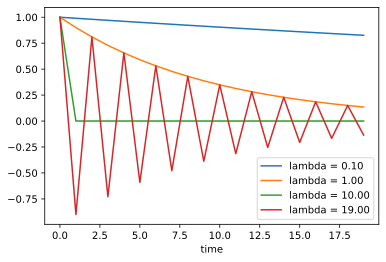

In [ ]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

为了分析动量的收敛情况，我们首先用两个标量重写更新方程：一个用于$x$，另一个用于动量$v$。这产生了：

$$
\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}.
$$

我们用$\mathbf{R}$来表示$2 \times 2$管理的收敛表现。
在$t$步之后，最初的值$[v_0, x_0]$变为$\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$。
因此，收敛速度是由$\mathbf{R}$的特征值决定的。
请参阅[文章](https://distill.pub/2017/momentum/) :cite:`Goh.2017`了解精彩动画。
请参阅 :cite:`Flammarion.Bach.2015`了解详细分析。
简而言之，当$0 < \eta \lambda < 2 + 2 \beta$时动量收敛。
与梯度下降的$0 < \eta \lambda < 2$相比，这是更大范围的可行参数。
另外，一般而言较大值的$\beta$是可取的。

## 小结

* 动量法用过去梯度的平均值来替换梯度，这大大加快了收敛速度。
* 对于无噪声梯度下降和嘈杂随机梯度下降，动量法都是可取的。
* 动量法可以防止在随机梯度下降的优化过程停滞的问题。
* 由于对过去的数据进行了指数降权，有效梯度数为$\frac{1}{1-\beta}$。
* 在凸二次问题中，可以对动量法进行明确而详细的分析。
* 动量法的实现非常简单，但它需要我们存储额外的状态向量（动量$\mathbf{v}$）。

## 练习

1. 使用动量超参数和学习率的其他组合，观察和分析不同的实验结果。
1. 试试梯度下降和动量法来解决一个二次问题，其中你有多个特征值，即$f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$，例如$\lambda_i = 2^{-i}$。绘制出$x$的值在初始化$x_i = 1$时如何下降。
1. 推导$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$的最小值和最小化器。
1. 当我们执行带动量法的随机梯度下降时会有什么变化？当我们使用带动量法的小批量随机梯度下降时会发生什么？试验参数如何？


# AdaGrad算法
:label:`sec_adagrad`

我们从有关特征学习中并不常见的问题入手。

## 稀疏特征和学习率

假设我们正在训练一个语言模型。
为了获得良好的准确性，我们大多希望在训练的过程中降低学习率，速度通常为$\mathcal{O}(t^{-\frac{1}{2}})$或更低。
现在讨论关于稀疏特征（即只在偶尔出现的特征）的模型训练，这对自然语言来说很常见。
例如，我们看到“预先条件”这个词比“学习”这个词的可能性要小得多。
但是，它在计算广告学和个性化协同过滤等其他领域也很常见。

只有在这些不常见的特征出现时，与其相关的参数才会得到有意义的更新。
鉴于学习率下降，我们可能最终会面临这样的情况：常见特征的参数相当迅速地收敛到最佳值，而对于不常见的特征，我们仍缺乏足够的观测以确定其最佳值。
换句话说，学习率要么对于常见特征而言降低太慢，要么对于不常见特征而言降低太快。

解决此问题的一个方法是记录我们看到特定特征的次数，然后将其用作调整学习率。
即我们可以使用大小为$\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$的学习率，而不是$\eta = \frac{\eta_0}{\sqrt{t + c}}$。
在这里$s(i, t)$计下了我们截至$t$时观察到功能$i$的次数。
这其实很容易实施且不产生额外损耗。

AdaGrad算法 :cite:`Duchi.Hazan.Singer.2011`通过将粗略的计数器$s(i, t)$替换为先前观察所得梯度的平方之和来解决这个问题。
它使用$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$来调整学习率。
这有两个好处：首先，我们不再需要决定梯度何时算足够大。
其次，它会随梯度的大小自动变化。通常对应于较大梯度的坐标会显著缩小，而其他梯度较小的坐标则会得到更平滑的处理。
在实际应用中，它促成了计算广告学及其相关问题中非常有效的优化程序。
但是，它遮盖了AdaGrad固有的一些额外优势，这些优势在预处理环境中很容易被理解。

## 预处理

凸优化问题有助于分析算法的特点。
毕竟对于大多数非凸问题来说，获得有意义的理论保证很难，但是直觉和洞察往往会延续。
让我们来看看最小化$f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$这一问题。

正如在 :numref:`sec_momentum`中那样，我们可以根据其特征分解$\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$重写这个问题，来得到一个简化得多的问题，使每个坐标都可以单独解出：

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$$

在这里我们使用了$\mathbf{x} = \mathbf{U} \mathbf{x}$，且因此$\mathbf{c} = \mathbf{U} \mathbf{c}$。
修改后优化器为$\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$且最小值为$-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$。
这样更容易计算，因为$\boldsymbol{\Lambda}$是一个包含$\mathbf{Q}$特征值的对角矩阵。

如果稍微扰动$\mathbf{c}$，我们会期望在$f$的最小化器中只产生微小的变化。
遗憾的是，情况并非如此。
虽然$\mathbf{c}$的微小变化导致了$\bar{\mathbf{c}}$同样的微小变化，但$f$的（以及$\bar{f}$的）最小化器并非如此。
每当特征值$\boldsymbol{\Lambda}_i$很大时，我们只会看到$\bar{x}_i$和$\bar{f}$的最小值发声微小变化。
相反，对于小的$\boldsymbol{\Lambda}_i$来说，$\bar{x}_i$的变化可能是剧烈的。
最大和最小的特征值之比称为优化问题的*条件数*（condition number）。

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.$$

如果条件编号$\kappa$很大，准确解决优化问题就会很难。
我们需要确保在获取大量动态的特征值范围时足够谨慎：难道我们不能简单地通过扭曲空间来“修复”这个问题，从而使所有特征值都是$1$？
理论上这很容易：我们只需要$\mathbf{Q}$的特征值和特征向量即可将问题从$\mathbf{x}$整理到$\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$中的一个。
在新的坐标系中，$\mathbf{x}^\top \mathbf{Q} \mathbf{x}$可以被简化为$\|\mathbf{z}\|^2$。
可惜，这是一个相当不切实际的想法。
一般而言，计算特征值和特征向量要比解决实际问题“贵”得多。

虽然准确计算特征值可能会很昂贵，但即便只是大致猜测并计算它们，也可能已经比不做任何事情好得多。
特别是，我们可以使用$\mathbf{Q}$的对角线条目并相应地重新缩放它。
这比计算特征值开销小的多。

$$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).$$

在这种情况下，我们得到了$\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$，特别注意对于所有$i$，$\tilde{\mathbf{Q}}_{ii} = 1$。
在大多数情况下，这大大简化了条件数。
例如我们之前讨论的案例，它将完全消除眼下的问题，因为问题是轴对齐的。

遗憾的是，我们还面临另一个问题：在深度学习中，我们通常情况甚至无法计算目标函数的二阶导数：对于$\mathbf{x} \in \mathbb{R}^d$，即使只在小批量上，二阶导数可能也需要$\mathcal{O}(d^2)$空间来计算，导致几乎不可行。
AdaGrad算法巧妙的思路是，使用一个代理来表示黑塞矩阵（Hessian）的对角线，既相对易于计算又高效。

为了了解它是如何生效的，让我们来看看$\bar{f}(\bar{\mathbf{x}})$。
我们有

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),$$

其中$\bar{\mathbf{x}}_0$是$\bar{f}$的优化器。
因此，梯度的大小取决于$\boldsymbol{\Lambda}$和与最佳值的差值。
如果$\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$没有改变，那这就是我们所求的。
毕竟在这种情况下，梯度$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$的大小就足够了。
由于AdaGrad算法是一种随机梯度下降算法，所以即使是在最佳值中，我们也会看到具有非零方差的梯度。
因此，我们可以放心地使用梯度的方差作为黑塞矩阵比例的廉价替代。
详尽的分析（要花几页解释）超出了本节的范围，请读者参考 :cite:`Duchi.Hazan.Singer.2011`。

## 算法

让我们接着上面正式开始讨论。
我们使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

在这里，操作是按照坐标顺序应用。
也就是说，$\mathbf{v}^2$有条目$v_i^2$。
同样，$\frac{1}{\sqrt{v}}$有条目$\frac{1}{\sqrt{v_i}}$，
并且$\mathbf{u} \cdot \mathbf{v}$有条目$u_i v_i$。
与之前一样，$\eta$是学习率，$\epsilon$是一个为维持数值稳定性而添加的常数，用来确保我们不会除以$0$。
最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

就像在动量法中我们需要跟踪一个辅助变量一样，在AdaGrad算法中，我们允许每个坐标有单独的学习率。
与SGD算法相比，这并没有明显增加AdaGrad的计算代价，因为主要计算用在$l(y_t, f(\mathbf{x}_t, \mathbf{w}))$及其导数。

请注意，在$\mathbf{s}_t$中累加平方梯度意味着$\mathbf{s}_t$基本上以线性速率增长（由于梯度从最初开始衰减，实际上比线性慢一些）。
这产生了一个学习率$\mathcal{O}(t^{-\frac{1}{2}})$，但是在单个坐标的层面上进行了调整。
对于凸问题，这完全足够了。
然而，在深度学习中，我们可能希望更慢地降低学习率。
这引出了许多AdaGrad算法的变体，我们将在后续章节中讨论它们。
眼下让我们先看看它在二次凸问题中的表现如何。
我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。
可以看到，自变量的迭代轨迹较平滑。
但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。


In [ ]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

epoch 20, x1: -2.382563, x2: -0.158591


/home/d2l-worker/miniconda3/envs/d2l-zh-release-1/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


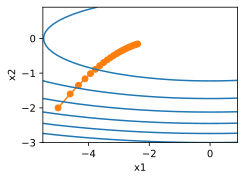

In [ ]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

我们将学习率提高到$2$，可以看到更好的表现。
这已经表明，即使在无噪声的情况下，学习率的降低可能相当剧烈，我们需要确保参数能够适当地收敛。


epoch 20, x1: -0.002295, x2: -0.000000


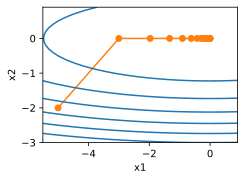

In [ ]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 从零开始实现

同动量法一样，AdaGrad算法需要对每个自变量维护同它一样形状的状态变量。


In [ ]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

与 :numref:`sec_minibatch_sgd`一节中的实验相比，这里使用更大的学习率来训练模型。


loss: 0.242, 0.013 sec/epoch


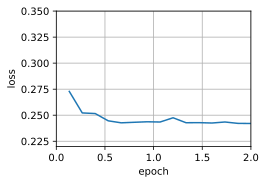

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## 简洁实现

我们可直接使用深度学习框架中提供的AdaGrad算法来训练模型。


loss: 0.243, 0.012 sec/epoch


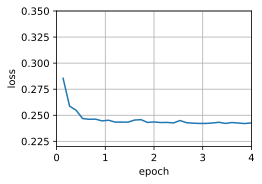

In [ ]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

## 小结

* AdaGrad算法会在单个坐标层面动态降低学习率。
* AdaGrad算法利用梯度的大小作为调整进度速率的手段：用较小的学习率来补偿带有较大梯度的坐标。
* 在深度学习问题中，由于内存和计算限制，计算准确的二阶导数通常是不可行的。梯度可以作为一个有效的代理。
* 如果优化问题的结构相当不均匀，AdaGrad算法可以帮助缓解扭曲。
* AdaGrad算法对于稀疏特征特别有效，在此情况下由于不常出现的问题，学习率需要更慢地降低。
* 在深度学习问题上，AdaGrad算法有时在降低学习率方面可能过于剧烈。我们将在 :numref:`sec_adam`一节讨论缓解这种情况的策略。

## 练习

1. 证明对于正交矩阵$\mathbf{U}$和向量$\mathbf{c}$，以下等式成立：$\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$。为什么这意味着在变量的正交变化之后，扰动的程度不会改变？
1. 尝试对函数$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$、以及它旋转45度后的函数即$f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$使用AdaGrad算法。它的表现会不同吗？
1. 证明[格什戈林圆盘定理](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem)，其中提到，矩阵$\mathbf{M}$的特征值$\lambda_i$在至少一个$j$的选项中满足$|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$的要求。
1. 关于对角线预处理矩阵$\mathrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{M})$的特征值，格什戈林的定理告诉了我们什么？
1. 尝试对适当的深度网络使用AdaGrad算法，例如，:numref:`sec_lenet`中应用于Fashion-MNIST的深度网络。
1. 你要如何修改AdaGrad算法，才能使其在学习率方面的衰减不那么激进？


# RMSProp算法
:label:`sec_rmsprop`

 :numref:`sec_adagrad`中的关键问题之一，是学习率按预定时间表$\mathcal{O}(t^{-\frac{1}{2}})$显著降低。
虽然这通常适用于凸问题，但对于深度学习中遇到的非凸问题，可能并不理想。
但是，作为一个预处理器，Adagrad算法按坐标顺序的适应性是非常可取的。

 :cite:`Tieleman.Hinton.2012`建议以RMSProp算法作为将速率调度与坐标自适应学习率分离的简单修复方法。
问题在于，Adagrad算法将梯度$\mathbf{g}_t$的平方累加成状态矢量$\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$。
因此，由于缺乏规范化，没有约束力，$\mathbf{s}_t$持续增长，几乎上是在算法收敛时呈线性递增。

解决此问题的一种方法是使用$\mathbf{s}_t / t$。
对于$\mathbf{g}_t$的合理分布来说，它将收敛。
遗憾的是，限制行为生效可能需要很长时间，因为该流程记住了值的完整轨迹。
另一种方法是按动量法中的方式使用泄漏平均值，即$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$，其中参数$\gamma > 0$。
保持所有其它部分不变就产生了RMSProp算法。

## 算法

让我们详细写出这些方程式。

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

常数$\epsilon > 0$通常设置为$10^{-6}$，以确保我们不会因除以零或步长过大而受到影响。
鉴于这种扩展，我们现在可以自由控制学习率$\eta$，而不考虑基于每个坐标应用的缩放。
就泄漏平均值而言，我们可以采用与之前在动量法中适用的相同推理。
扩展$\mathbf{s}_t$定义可获得

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

同之前在 :numref:`sec_momentum`小节一样，我们使用$1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$。
因此，权重总和标准化为$1$且观测值的半衰期为$\gamma^{-1}$。
让我们图像化各种数值的$\gamma$在过去40个时间步长的权重。


In [ ]:
import math
import torch
from d2l import torch as d2l

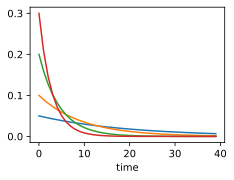

In [ ]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

## 从零开始实现

和之前一样，我们使用二次函数$f(\mathbf{x})=0.1x_1^2+2x_2^2$来观察RMSProp算法的轨迹。
回想在 :numref:`sec_adagrad`一节中，当我们使用学习率为0.4的Adagrad算法时，变量在算法的后期阶段移动非常缓慢，因为学习率衰减太快。
RMSProp算法中不会发生这种情况，因为$\eta$是单独控制的。


epoch 20, x1: -0.010599, x2: 0.000000


/home/d2l-worker/miniconda3/envs/d2l-zh-release-1/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


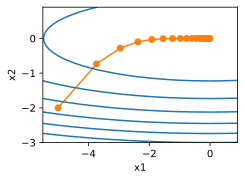

In [ ]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

接下来，我们在深度网络中实现RMSProp算法。


In [ ]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

In [ ]:
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

我们将初始学习率设置为0.01，加权项$\gamma$设置为0.9。
也就是说，$\mathbf{s}$累加了过去的$1/(1-\gamma) = 10$次平方梯度观测值的平均值。


loss: 0.243, 0.014 sec/epoch


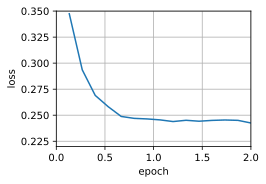

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

## 简洁实现

我们可直接使用深度学习框架中提供的RMSProp算法来训练模型。


loss: 0.247, 0.012 sec/epoch


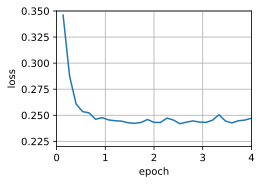

In [ ]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

## 小结

* RMSProp算法与Adagrad算法非常相似，因为两者都使用梯度的平方来缩放系数。
* RMSProp算法与动量法都使用泄漏平均值。但是，RMSProp算法使用该技术来调整按系数顺序的预处理器。
* 在实验中，学习率需要由实验者调度。
* 系数$\gamma$决定了在调整每坐标比例时历史记录的时长。

## 练习

1. 如果我们设置$\gamma = 1$，实验会发生什么？为什么？
1. 旋转优化问题以最小化$f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$。收敛会发生什么？
1. 试试在真正的机器学习问题上应用RMSProp算法会发生什么，例如在Fashion-MNIST上的训练。试验不同的取值来调整学习率。
1. 随着优化的进展，需要调整$\gamma$吗？RMSProp算法对此有多敏感？


# Adadelta
:label:`sec_adadelta`


Adadelta是AdaGrad的另一种变体（ :numref:`sec_adagrad`），
主要区别在于前者减少了学习率适应坐标的数量。
此外，广义上Adadelta被称为没有学习率，因为它使用变化量本身作为未来变化的校准。
Adadelta算法是在 :cite:`Zeiler.2012`中提出的。

## Adadelta算法

简而言之，Adadelta使用两个状态变量，$\mathbf{s}_t$用于存储梯度二阶导数的泄露平均值，$\Delta\mathbf{x}_t$用于存储模型本身中参数变化二阶导数的泄露平均值。请注意，为了与其他出版物和实现的兼容性，我们使用作者的原始符号和命名（没有其它真正理由让大家使用不同的希腊变量来表示在动量法、AdaGrad、RMSProp和Adadelta中用于相同用途的参数）。

以下是Adadelta的技术细节。鉴于参数du jour是$\rho$，我们获得了与 :numref:`sec_rmsprop`类似的以下泄漏更新：

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与 :numref:`sec_rmsprop`的区别在于，我们使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的梯度$\mathbf{g}_t'$是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

其中$\Delta \mathbf{x}_{t-1}$是重新缩放梯度的平方$\mathbf{g}_t'$的泄漏平均值。我们将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

和$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。

## 代码实现

Adadelta需要为每个变量维护两个状态变量，即$\mathbf{s}_t$和$\Delta\mathbf{x}_t$。这将产生以下实现。


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

对于每次参数更新，选择$\rho = 0.9$相当于10个半衰期。由此我们得到：


loss: 0.243, 0.015 sec/epoch


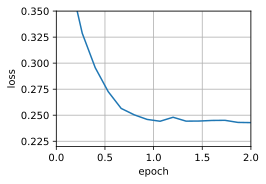

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用`Trainer`类中的`adadelta`算法。


loss: 0.243, 0.014 sec/epoch


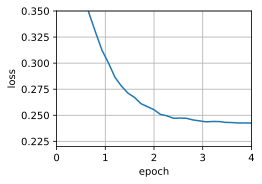

In [ ]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## 小结

* Adadelta没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
* Adadelta需要两个状态变量来存储梯度的二阶导数和参数的变化。
* Adadelta使用泄漏的平均值来保持对适当统计数据的运行估计。

## 练习

1. 调整$\rho$的值，会发生什么？
1. 展示如何在不使用$\mathbf{g}_t'$的情况下实现算法。为什么这是个好主意？
1. Adadelta真的是学习率为0吗？你能找到Adadelta无法解决的优化问题吗？
1. 将Adadelta的收敛行为与AdaGrad和RMSProp进行比较。


# Adadelta
:label:`sec_adadelta`


Adadelta是AdaGrad的另一种变体（ :numref:`sec_adagrad`），
主要区别在于前者减少了学习率适应坐标的数量。
此外，广义上Adadelta被称为没有学习率，因为它使用变化量本身作为未来变化的校准。
Adadelta算法是在 :cite:`Zeiler.2012`中提出的。

## Adadelta算法

简而言之，Adadelta使用两个状态变量，$\mathbf{s}_t$用于存储梯度二阶导数的泄露平均值，$\Delta\mathbf{x}_t$用于存储模型本身中参数变化二阶导数的泄露平均值。请注意，为了与其他出版物和实现的兼容性，我们使用作者的原始符号和命名（没有其它真正理由让大家使用不同的希腊变量来表示在动量法、AdaGrad、RMSProp和Adadelta中用于相同用途的参数）。

以下是Adadelta的技术细节。鉴于参数du jour是$\rho$，我们获得了与 :numref:`sec_rmsprop`类似的以下泄漏更新：

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与 :numref:`sec_rmsprop`的区别在于，我们使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的梯度$\mathbf{g}_t'$是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

其中$\Delta \mathbf{x}_{t-1}$是重新缩放梯度的平方$\mathbf{g}_t'$的泄漏平均值。我们将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

和$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。

## 代码实现

Adadelta需要为每个变量维护两个状态变量，即$\mathbf{s}_t$和$\Delta\mathbf{x}_t$。这将产生以下实现。


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

对于每次参数更新，选择$\rho = 0.9$相当于10个半衰期。由此我们得到：


loss: 0.243, 0.015 sec/epoch


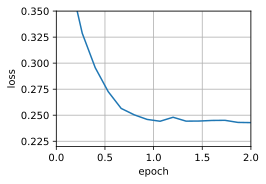

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用`Trainer`类中的`adadelta`算法。


loss: 0.243, 0.014 sec/epoch


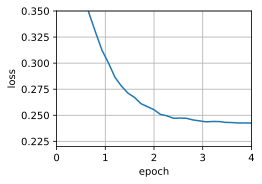

In [ ]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## 小结

* Adadelta没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
* Adadelta需要两个状态变量来存储梯度的二阶导数和参数的变化。
* Adadelta使用泄漏的平均值来保持对适当统计数据的运行估计。

## 练习

1. 调整$\rho$的值，会发生什么？
1. 展示如何在不使用$\mathbf{g}_t'$的情况下实现算法。为什么这是个好主意？
1. Adadelta真的是学习率为0吗？你能找到Adadelta无法解决的优化问题吗？
1. 将Adadelta的收敛行为与AdaGrad和RMSProp进行比较。


[Discussions](https://discuss.d2l.ai/t/5772)


# Adam算法
:label:`sec_adam`

本章我们已经学习了许多有效优化的技术。
在本节讨论之前，我们先详细回顾一下这些技术：

* 在 :numref:`sec_sgd`中，我们学习了：随机梯度下降在解决优化问题时比梯度下降更有效。
* 在 :numref:`sec_minibatch_sgd`中，我们学习了：在一个小批量中使用更大的观测值集，可以通过向量化提供额外效率。这是高效的多机、多GPU和整体并行处理的关键。
* 在 :numref:`sec_momentum`中我们添加了一种机制，用于汇总过去梯度的历史以加速收敛。
* 在 :numref:`sec_adagrad`中，我们通过对每个坐标缩放来实现高效计算的预处理器。
* 在 :numref:`sec_rmsprop`中，我们通过学习率的调整来分离每个坐标的缩放。

Adam算法 :cite:`Kingma.Ba.2014`将所有这些技术汇总到一个高效的学习算法中。
不出预料，作为深度学习中使用的更强大和有效的优化算法之一，它非常受欢迎。
但是它并非没有问题，尤其是 :cite:`Reddi.Kale.Kumar.2019`表明，有时Adam算法可能由于方差控制不良而发散。
在完善工作中， :cite:`Zaheer.Reddi.Sachan.ea.2018`给Adam算法提供了一个称为Yogi的热补丁来解决这些问题。
下面我们了解一下Adam算法。

## 算法

Adam算法的关键组成部分之一是：它使用指数加权移动平均值来估算梯度的动量和二次矩，即它使用状态变量

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里$\beta_1$和$\beta_2$是非负加权参数。
常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
也就是说，方差估计的移动远远慢于动量估计的移动。
注意，如果我们初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
我们可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
相应地，标准化状态变量由下式获得

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

有了正确的估计，我们现在可以写出更新方程。
首先，我们以非常类似于RMSProp算法的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与RMSProp不同，我们的更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身。
此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
前者在实践中效果略好一些，因此与RMSProp算法有所区分。
通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。

最后，我们简单更新：

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

回顾Adam算法，它的设计灵感很清楚：
首先，动量和规模在状态变量中清晰可见，
它们相当独特的定义使我们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。
其次，RMSProp算法中两项的组合都非常简单。
最后，明确的学习率$\eta$使我们能够控制步长来解决收敛问题。

## 实现

从头开始实现Adam算法并不难。
为方便起见，我们将时间步$t$存储在`hyperparams`字典中。
除此之外，一切都很简单。


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

现在，我们用以上Adam算法来训练模型，这里我们使用$\eta = 0.01$的学习率。


loss: 0.243, 0.015 sec/epoch


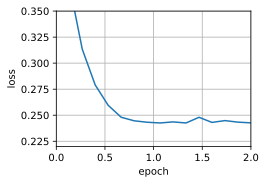

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

此外，我们可以用深度学习框架自带算法应用Adam算法，这里我们只需要传递配置参数。


loss: 0.243, 0.014 sec/epoch


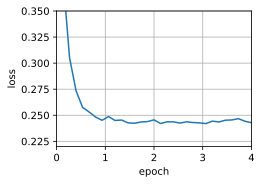

In [ ]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Yogi

Adam算法也存在一些问题：
即使在凸环境下，当$\mathbf{s}_t$的二次矩估计值爆炸时，它可能无法收敛。
 :cite:`Zaheer.Reddi.Sachan.ea.2018`为$\mathbf{s}_t$提出了的改进更新和参数初始化。
论文中建议我们重写Adam算法更新如下：

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

每当$\mathbf{g}_t^2$具有值很大的变量或更新很稀疏时，$\mathbf{s}_t$可能会太快地“忘记”过去的值。
一个有效的解决方法是将$\mathbf{g}_t^2 - \mathbf{s}_{t-1}$替换为$\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。
这就是Yogi更新，现在更新的规模不再取决于偏差的量。

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

论文中，作者还进一步建议用更大的初始批量来初始化动量，而不仅仅是初始的逐点估计。


loss: 0.244, 0.015 sec/epoch


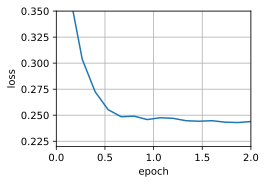

In [ ]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## 小结

* Adam算法将许多优化算法的功能结合到了相当强大的更新规则中。
* Adam算法在RMSProp算法基础上创建的，还在小批量的随机梯度上使用EWMA。
* 在估计动量和二次矩时，Adam算法使用偏差校正来调整缓慢的启动速度。
* 对于具有显著差异的梯度，我们可能会遇到收敛性问题。我们可以通过使用更大的小批量或者切换到改进的估计值$\mathbf{s}_t$来修正它们。Yogi提供了这样的替代方案。

## 练习

1. 调节学习率，观察并分析实验结果。
1. 你能重写动量和二次矩更新，从而使其不需要偏差校正吗？
1. 当我们收敛时，为什么你需要降低学习率$\eta$？
1. 尝试构造一个使用Adam算法会发散而Yogi会收敛的例子。


# 学习率调度器
:label:`sec_scheduler`

到目前为止，我们主要关注如何更新权重向量的优化算法，而不是它们的更新速率。
然而，调整学习率通常与实际算法同样重要，有如下几方面需要考虑：

* 首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要（有关详细信息，请参见 :numref:`sec_momentum`）。直观地说，这是最不敏感与最敏感方向的变化量的比率。
* 其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。 :numref:`sec_minibatch_sgd`比较详细地讨论了这一点，在 :numref:`sec_sgd`中我们则分析了性能保证。简而言之，我们希望速率衰减，但要比$\mathcal{O}(t^{-\frac{1}{2}})$慢，这样能成为解决凸问题的不错选择。
* 另一个同样重要的方面是初始化。这既涉及参数最初的设置方式（详情请参阅 :numref:`sec_numerical_stability`），又关系到它们最初的演变方式。这被戏称为*预热*（warmup），即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。
* 最后，还有许多优化变体可以执行周期性学习率调整。这超出了本章的范围，我们建议读者阅读 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`来了解个中细节。例如，如何通过对整个路径参数求平均值来获得更好的解。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动应对这个问题的工具。
在本章中，我们将梳理不同的调度策略对准确性的影响，并展示如何通过*学习率调度器*（learning rate scheduler）来有效管理。

## 一个简单的问题

我们从一个简单的问题开始，这个问题可以轻松计算，但足以说明要义。
为此，我们选择了一个稍微现代化的LeNet版本（激活函数使用`relu`而不是`sigmoid`，汇聚层使用最大汇聚层而不是平均汇聚层），并应用于Fashion-MNIST数据集。
此外，我们混合网络以提高性能。
由于大多数代码都是标准的，我们只介绍基础知识，而不做进一步的详细讨论。如果需要，请参阅 :numref:`chap_cnn`进行复习。


In [ ]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

让我们来看看如果使用默认设置，调用此算法会发生什么。
例如设学习率为$0.3$并训练$30$次迭代。
留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。
两条曲线之间的间隙表示过拟合。


train loss 0.194, train acc 0.925, test acc 0.859


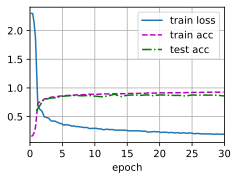

In [ ]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 学习率调度器

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。
例如，以动态的方式来响应优化的进展情况。


In [ ]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


更通常而言，我们应该定义一个调度器。
当调用更新次数时，它将返回学习率的适当值。
让我们定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [ ]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

让我们在一系列值上绘制它的行为。


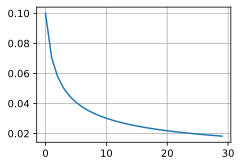

In [ ]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。
我们只是提供调度器作为训练算法的额外参数。


train loss 0.268, train acc 0.902, test acc 0.882


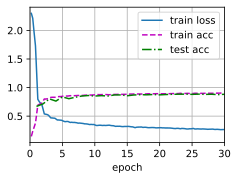

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

这比以前好一些：曲线比以前更加平滑，并且过拟合更小了。
遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，较小的步长将导致参数更接近零，因此更简单。
但是，这并不能完全解释这种现象，因为我们并没有真正地提前停止，而只是轻柔地降低了学习率。

## 策略

虽然我们不可能涵盖所有类型的学习率调度器，但我们会尝试在下面简要概述常用的策略：多项式衰减和分段常数表。
此外，余弦学习率调度在实践中的一些问题上运行效果很好。
在某些问题上，最好在使用较高的学习率之前预热优化器。

### 单因子调度器

多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。
为了防止学习率衰减到一个合理的下界之下，
更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。


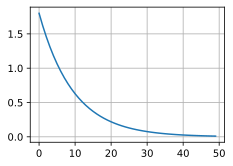

In [ ]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

接下来，我们将使用内置的调度器，但在这里仅解释它们的功能。

### 多因子调度器

训练深度网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。
具体地说，给定一组降低学习率的时间点，例如$s = \{5, 10, 20\}$，
每当$t \in s$时，降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
假设每步中的值减半，我们可以按如下方式实现这一点。


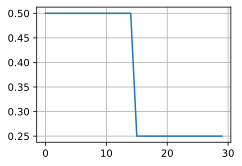

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。
此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。
下面的例子展示了如何使用这种方法产生更好的解决方案。


train loss 0.198, train acc 0.925, test acc 0.871


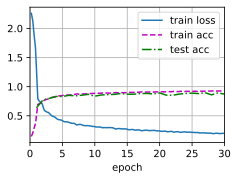

In [ ]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 余弦调度器

余弦调度器是 :cite:`Loshchilov.Hutter.2016`提出的一种启发式算法。
它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。
这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在$t \in [0, T]$之间。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。
此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。
在下面的示例中，我们设置了最大更新步数$T = 20$。


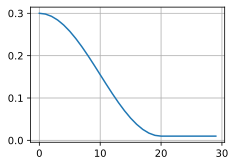

In [ ]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

在计算机视觉的背景下，这个调度方式可能产生改进的结果。
但请注意，如下所示，这种改进并不一定成立。


train loss 0.192, train acc 0.929, test acc 0.897


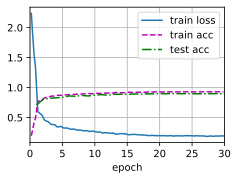

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 预热

在某些情况下，初始化参数不足以得到良好的解。
这对于某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。
对此，一方面，我们可以选择一个足够小的学习率，
从而防止一开始发散，然而这样进展太缓慢。
另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。
为了简单起见，通常使用线性递增。
这引出了如下表所示的时间表。


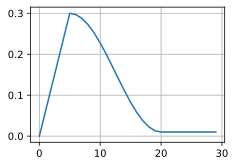

In [ ]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。


train loss 0.209, train acc 0.923, test acc 0.888


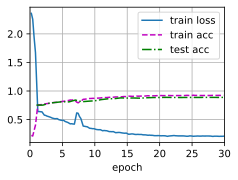

In [ ]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

预热可以应用于任何调度器，而不仅仅是余弦。
有关学习率调度的更多实验和更详细讨论，请参阅 :cite:`Gotmare.Keskar.Xiong.ea.2018`。
其中，这篇论文的点睛之笔的发现：预热阶段限制了非常深的网络中参数的发散量。
这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散。

## 小结

* 在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。
* 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。
* 余弦调度器在某些计算机视觉问题中很受欢迎。
* 优化之前的预热期可以防止发散。
* 优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。

## 练习

1. 试验给定固定学习率的优化行为。这种情况下你可以获得的最佳模型是什么？
1. 如果你改变学习率下降的指数，收敛性会如何改变？在实验中方便起见，使用`PolyScheduler`。
1. 将余弦调度器应用于大型计算机视觉问题，例如训练ImageNet数据集。与其他调度器相比，它如何影响性能？
1. 预热应该持续多长时间？
1. 你能把优化和采样联系起来吗？首先，在随机梯度朗之万动力学上使用 :cite:`Welling.Teh.2011`的结果。


[Discussions](https://discuss.d2l.ai/t/4334)
